<a href="https://colab.research.google.com/github/haryoa/pota/blob/master/Source_POSTAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code of Indonesia POSTAG problem

By : Haryo Akbarianto Wibowo


# How To Run
1. Run each cells from start until the end sequentally (HINT : used SHIFT + Enter to run each cell)
2. If you are going to run BERT model in this colaboratory, use the BERT model that I have provided in the email. You can test it by loading the model using torch.load . I have provided how to load it at the Evaluate Bert Model Section
3. I also provide logistic regression model that I've trained and can be loaded by using pickle if you don't want to train. Otherwise, just skip and see the result of the model.
4. The file that I provided are :
> 1. logreg.meong : The pickle file of Logistic Regression
> 2. vectorizer_lr.meong : the pickle file the vectorizer of Logistic Regression
> 3. torch_save_5 : the torch file







# Prepare Import and stuffs
This section will import all stuffs that will be used to solve kata.ai exercise  
For this exercise, I'm going to use Logistic Regression as the first task and BERT as the second task.

In [1]:
!git clone https://github.com/famrashel/idn-tagged-corpus
!pip install pytorch-pretrained-bert

Cloning into 'idn-tagged-corpus'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), done.
    100% |████████████████████████████████| 122kB 8.5MB/s 


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import pickle
from seqeval.metrics import f1_score, accuracy_score
from shutil import copyfile

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam
from tqdm import tqdm_notebook

Using TensorFlow backend.


Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [3]:
!pip install adabound
!pip install seqeval
import adabound

## Functions

In [0]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes."""

from __future__ import absolute_import, division, print_function, unicode_literals

import collections
import logging
import os
import unicodedata
from io import open

from pytorch_pretrained_bert.file_utils import cached_path

logger = logging.getLogger(__name__)

PRETRAINED_VOCAB_ARCHIVE_MAP = {
    'bert-base-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt",
    'bert-large-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-uncased-vocab.txt",
    'bert-base-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt",
    'bert-large-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt",
    'bert-base-multilingual-uncased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt",
    'bert-base-multilingual-cased': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-cased-vocab.txt",
    'bert-base-chinese': "https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-chinese-vocab.txt",
}
PRETRAINED_VOCAB_POSITIONAL_EMBEDDINGS_SIZE_MAP = {
    'bert-base-uncased': 512,
    'bert-large-uncased': 512,
    'bert-base-cased': 512,
    'bert-large-cased': 512,
    'bert-base-multilingual-uncased': 512,
    'bert-base-multilingual-cased': 512,
    'bert-base-chinese': 512,
}
VOCAB_NAME = 'vocab.txt'


def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    index = 0
    with open(vocab_file, "r", encoding="utf-8") as reader:
        while True:
            token = reader.readline()
            if not token:
                break
            token = token.strip()
            vocab[token] = index
            index += 1
    return vocab


def whitespace_tokenize(text):
    """Runs basic whitespace cleaning and splitting on a piece of text."""
    text = text.strip()
    if not text:
        return []
    tokens = text.split()
    return tokens


class BertTokenizer(object):
    """Runs end-to-end tokenization: punctuation splitting + wordpiece"""

    def __init__(self, vocab_file, do_lower_case=True, max_len=None, do_basic_tokenize=True,
                 never_split=("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")):
        """Constructs a BertTokenizer.
        Args:
          vocab_file: Path to a one-wordpiece-per-line vocabulary file
          do_lower_case: Whether to lower case the input
                         Only has an effect when do_wordpiece_only=False
          do_basic_tokenize: Whether to do basic tokenization before wordpiece.
          max_len: An artificial maximum length to truncate tokenized sequences to;
                         Effective maximum length is always the minimum of this
                         value (if specified) and the underlying BERT model's
                         sequence length.
          never_split: List of tokens which will never be split during tokenization.
                         Only has an effect when do_wordpiece_only=False
        """
        if not os.path.isfile(vocab_file):
            raise ValueError(
                "Can't find a vocabulary file at path '{}'. To load the vocabulary from a Google pretrained "
                "model use `tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)`".format(vocab_file))
        self.vocab = load_vocab(vocab_file)
        self.ids_to_tokens = collections.OrderedDict(
            [(ids, tok) for tok, ids in self.vocab.items()])
        self.do_basic_tokenize = do_basic_tokenize
        if do_basic_tokenize:
          self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case,
                                                never_split=never_split)
        self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)
        self.max_len = max_len if max_len is not None else int(1e12)

    def tokenize(self, text):
        split_tokens = []
        if self.do_basic_tokenize:
            for token in self.basic_tokenizer.tokenize(text):
                for sub_token in self.wordpiece_tokenizer.tokenize(token):
                    split_tokens.append(sub_token)
        else:
            split_tokens = self.wordpiece_tokenizer.tokenize(text)
        return split_tokens

    def convert_tokens_to_ids(self, tokens):
        """Converts a sequence of tokens into ids using the vocab."""
        ids = []
        for token in tokens:
            ids.append(self.vocab[token])
        if len(ids) > self.max_len:
            logger.warning(
                "Token indices sequence length is longer than the specified maximum "
                " sequence length for this BERT model ({} > {}). Running this"
                " sequence through BERT will result in indexing errors".format(len(ids), self.max_len)
            )
        return ids

    def convert_ids_to_tokens(self, ids):
        """Converts a sequence of ids in wordpiece tokens using the vocab."""
        tokens = []
        for i in ids:
            tokens.append(self.ids_to_tokens[i])
        return tokens

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, cache_dir=None, *inputs, **kwargs):
        """
        Instantiate a PreTrainedBertModel from a pre-trained model file.
        Download and cache the pre-trained model file if needed.
        """
        if pretrained_model_name_or_path in PRETRAINED_VOCAB_ARCHIVE_MAP:
            vocab_file = PRETRAINED_VOCAB_ARCHIVE_MAP[pretrained_model_name_or_path]
            if '-cased' in pretrained_model_name_or_path and kwargs.get('do_lower_case', True):
                logger.warning("The pre-trained model you are loading is a cased model but you have not set "
                               "`do_lower_case` to False. We are setting `do_lower_case=False` for you but "
                               "you may want to check this behavior.")
                kwargs['do_lower_case'] = False
            elif '-cased' not in pretrained_model_name_or_path and not kwargs.get('do_lower_case', True):
                logger.warning("The pre-trained model you are loading is an uncased model but you have set "
                               "`do_lower_case` to False. We are setting `do_lower_case=True` for you "
                               "but you may want to check this behavior.")
                kwargs['do_lower_case'] = True
        else:
            vocab_file = pretrained_model_name_or_path
        if os.path.isdir(vocab_file):
            vocab_file = os.path.join(vocab_file, VOCAB_NAME)
        # redirect to the cache, if necessary
        try:
            resolved_vocab_file = cached_path(vocab_file, cache_dir=cache_dir)
        except EnvironmentError:
            logger.error(
                "Model name '{}' was not found in model name list ({}). "
                "We assumed '{}' was a path or url but couldn't find any file "
                "associated to this path or url.".format(
                    pretrained_model_name_or_path,
                    ', '.join(PRETRAINED_VOCAB_ARCHIVE_MAP.keys()),
                    vocab_file))
            return None
        if resolved_vocab_file == vocab_file:
            logger.info("loading vocabulary file {}".format(vocab_file))
        else:
            logger.info("loading vocabulary file {} from cache at {}".format(
                vocab_file, resolved_vocab_file))
        if pretrained_model_name_or_path in PRETRAINED_VOCAB_POSITIONAL_EMBEDDINGS_SIZE_MAP:
            # if we're using a pretrained model, ensure the tokenizer wont index sequences longer
            # than the number of positional embeddings
            max_len = PRETRAINED_VOCAB_POSITIONAL_EMBEDDINGS_SIZE_MAP[pretrained_model_name_or_path]
            kwargs['max_len'] = min(kwargs.get('max_len', int(1e12)), max_len)
        # Instantiate tokenizer.
        tokenizer = cls(resolved_vocab_file, *inputs, **kwargs)
        return tokenizer


class BasicTokenizer(object):
    """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

    def __init__(self,
                 do_lower_case=True,
                 never_split=("[UNK]", "[SEP]", "[PAD]", "[CLS]", "[MASK]")):
        """Constructs a BasicTokenizer.
        Args:
          do_lower_case: Whether to lower case the input.
        """
        self.do_lower_case = do_lower_case
        self.never_split = never_split

    def tokenize(self, text):
        """Tokenizes a piece of text."""
        text = self._clean_text(text)
        # This was added on November 1st, 2018 for the multilingual and Chinese
        # models. This is also applied to the English models now, but it doesn't
        # matter since the English models were not trained on any Chinese data
        # and generally don't have any Chinese data in them (there are Chinese
        # characters in the vocabulary because Wikipedia does have some Chinese
        # words in the English Wikipedia.).
        text = self._tokenize_chinese_chars(text)
        orig_tokens = whitespace_tokenize(text)
        split_tokens = []
        for token in orig_tokens:
            if self.do_lower_case and token not in self.never_split:
                token = token.lower()
                token = self._run_strip_accents(token)
            split_tokens.extend(self._run_split_on_punc(token))

        output_tokens = whitespace_tokenize(" ".join(split_tokens))
        return output_tokens

    def _run_strip_accents(self, text):
        """Strips accents from a piece of text."""
        text = unicodedata.normalize("NFD", text)
        output = []
        for char in text:
            cat = unicodedata.category(char)
            if cat == "Mn":
                continue
            output.append(char)
        return "".join(output)

    def _run_split_on_punc(self, text):
        """Splits punctuation on a piece of text."""
        if text in self.never_split:
            return [text]
        chars = list(text)
        i = 0
        start_new_word = True
        output = []
        while i < len(chars):
            char = chars[i]
            if _is_punctuation(char):
                output.append([char])
                start_new_word = True
            else:
                if start_new_word:
                    output.append([])
                start_new_word = False
                output[-1].append(char)
            i += 1

        return ["".join(x) for x in output]

    def _tokenize_chinese_chars(self, text):
        """Adds whitespace around any CJK character."""
        output = []
        for char in text:
            cp = ord(char)
            if self._is_chinese_char(cp):
                output.append(" ")
                output.append(char)
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)

    def _is_chinese_char(self, cp):
        """Checks whether CP is the codepoint of a CJK character."""
        # This defines a "chinese character" as anything in the CJK Unicode block:
        #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
        #
        # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
        # despite its name. The modern Korean Hangul alphabet is a different block,
        # as is Japanese Hiragana and Katakana. Those alphabets are used to write
        # space-separated words, so they are not treated specially and handled
        # like the all of the other languages.
        if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
                (cp >= 0x3400 and cp <= 0x4DBF) or  #
                (cp >= 0x20000 and cp <= 0x2A6DF) or  #
                (cp >= 0x2A700 and cp <= 0x2B73F) or  #
                (cp >= 0x2B740 and cp <= 0x2B81F) or  #
                (cp >= 0x2B820 and cp <= 0x2CEAF) or
                (cp >= 0xF900 and cp <= 0xFAFF) or  #
                (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
            return True

        return False

    def _clean_text(self, text):
        """Performs invalid character removal and whitespace cleanup on text."""
        output = []
        for char in text:
            cp = ord(char)
            if cp == 0 or cp == 0xfffd or _is_control(char):
                continue
            if _is_whitespace(char):
                output.append(" ")
            else:
                output.append(char)
        return "".join(output)


class WordpieceTokenizer(object):
    """Runs WordPiece tokenization."""

    def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=100):
        self.vocab = vocab
        self.unk_token = unk_token
        self.max_input_chars_per_word = max_input_chars_per_word

    def tokenize(self, text):
        """Tokenizes a piece of text into its word pieces.
        This uses a greedy longest-match-first algorithm to perform tokenization
        using the given vocabulary.
        For example:
          input = "unaffable"
          output = ["un", "##aff", "##able"]
        Args:
          text: A single token or whitespace separated tokens. This should have
            already been passed through `BasicTokenizer`.
        Returns:
          A list of wordpiece tokens.
        """

        output_tokens = []
        for token in whitespace_tokenize(text):
            chars = list(token)
            if len(chars) > self.max_input_chars_per_word:
                output_tokens.append(self.unk_token)
                continue

            is_bad = False
            start = 0
            sub_tokens = []
            while start < len(chars):
                end = len(chars)
                cur_substr = None
                while start < end:
                    substr = "".join(chars[start:end])
                    if start > 0:
                        substr = "##" + substr
                    if substr in self.vocab:
                        cur_substr = substr
                        break
                    end -= 1
                if cur_substr is None:
                    is_bad = True
                    break
                sub_tokens.append(cur_substr)
                start = end

            if is_bad:
                output_tokens.append(self.unk_token)
            else:
                output_tokens.extend(sub_tokens)
        return output_tokens


def _is_whitespace(char):
    """Checks whether `chars` is a whitespace character."""
    # \t, \n, and \r are technically contorl characters but we treat them
    # as whitespace since they are generally considered as such.
    if char == " " or char == "\t" or char == "\n" or char == "\r":
        return True
    cat = unicodedata.category(char)
    if cat == "Zs":
        return True
    return False


def _is_control(char):
    """Checks whether `chars` is a control character."""
    # These are technically control characters but we count them as whitespace
    # characters.
    if char == "\t" or char == "\n" or char == "\r":
        return False
    cat = unicodedata.category(char)
    if cat.startswith("C"):
        return True
    return False


def _is_punctuation(char):
    """Checks whether `chars` is a punctuation character."""
    cp = ord(char)
    # We treat all non-letter/number ASCII as punctuation.
    # Characters such as "^", "$", and "`" are not in the Unicode
    # Punctuation class but we treat them as punctuation anyways, for
    # consistency.
    if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
            (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
        return True
    cat = unicodedata.category(char)
    if cat.startswith("P"):
        return True
    return False
  
def read_tsv_postag(filename):
  """Used for visualization
  
  """
  all_tokens, all_tags = [],[]
  
  with open(filename, 'r') as tsv_file:
    
    for line in tsv_file:
      # Since each line separated by '\t'. Split it
      line = line.split('\t')
      
      if len(line) == 2:
        all_tokens.append(line[0])
        all_tags.append(line[1].strip())

  return all_tokens, all_tags
        
        
        
def read_tsv_postag_2(filename):
  """Used for training the model
  
  """
  all_sentences = []
  
  with open(filename, 'r') as tsv_file:
    current_sentence = []
    for line in tsv_file:
      # Since each line separated by '\t'. Split it
      line = line.split('\t')
      
      if len(line) == 2:
        tokens = line[0]
        tag = line[1].strip()
        splitted_tokens = tokens.split()
        
        # For an instance that contains more than one tokens
        if len(splitted_tokens) > 1: 
          for token in splitted_tokens:
            current_sentence.append((token, tag.upper()))
        else:
          current_sentence.append((tokens, tag.upper()))
      else:
        all_sentences.append(current_sentence)
        current_sentence = []
      
  return all_sentences

from IPython.core.display import display, HTML
def print_evaluate(y_test, y_test_pred, title="Evaluation", print_conf_mat=True):
  """ Print the evaluation of the model. Accuracy, Recall, Precision, and F1
  
  """
  display(HTML('<h1>{}</h1>'.format(title)))
  acc_score = accuracy_score(y_test, y_test_pred)
  print("Accuracy : {}".format(accuracy_score(y_test, y_test_pred)))
  print(classification_report(y_test, y_test_pred, digits=4))
  if print_conf_mat:
    labels_confusion = np.unique(y_test)
    cf_m = confusion_matrix(y_test,y_test_pred, labels=labels_confusion)
    df_cm = pd.DataFrame(cf_m, index = labels_confusion,
                    columns = labels_confusion)
    plt.figure(figsize = (20,12))
    sn.heatmap(df_cm, annot=True, fmt='g')
  return acc_score, classification_report(y_test, y_test_pred,digits=4, output_dict=True)

def ablation(training_sentences, test_sentences):
  """
    Do Feature Ablation
  """
  features = ['token','is_first', 'is_last', 'is_capitalized', 'is_numeric', 
              'is_alphannumeric', 'prefix_1', 'prefix_2', 'prefix_3',
              'sufix_1','sufix_2','sufix_3','prev_token','2_prev_token',
              'next_token','2_next_token','contains_strip','consonant','sonant']
  accs = []
  f1_evals = []

  for feature in features:
    print("Experiment on deleting feature {}".format(feature))
    vectorizer = DictVectorizer()
    X_train, y_train = create_data_input_output(training_sentences, feature)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                                random_state=444, test_size=0.1)

    X_test, y_test = create_data_input_output(test_sentences)
    X_transform_train = vectorizer.fit_transform(X_train)
    X_transform_test = vectorizer.transform(X_test)
    X_transform_val = vectorizer.transform(X_val)
    
    from sklearn.linear_model import LogisticRegression

    model_ablation = LogisticRegression(n_jobs=-1, solver='lbfgs', 
                               multi_class='multinomial', 
                               class_weight='balanced')                         
    model_ablation.fit(X_transform_train, y_train) # Train model
    y_test_pred = model_ablation.predict(X_transform_test)
    acc, f1_eval = print_evaluate(y_test, y_test_pred, title='ablation {}'.format(feature), print_conf_mat=False)
    accs.append(acc)
    f1_evals.append(f1_eval)
  return accs, f1_evals

def create_data_input_output(sentences, delete_feature=None):
  """ Create datasets for the machine learning input and output 
  """
  input_ml, output_ml = [], []

  for sent in sentences:
    for token_index, token_tag_pair in enumerate(sent):
        token = token_tag_pair[0]
        postag_label = token_tag_pair[1]

        input_ml.append(extract_features(token, token_index, sent, delete=delete_feature))
        output_ml.append(postag_label)
        
  return input_ml,output_ml
  
  
def extract_features(token, token_index, sent, delete = None):
  """
    Extract the features
  """
  token_features = {
      'token' : token,
      'is_first' : token_index == 0,
      'is_last' : token_index == len(sent) - 1,
      'is_capitalized' : token[0].isupper(),
      'is_numeric' : token.isdigit(),
      'is_alphannumeric' : token.isalnum(),
      
      'prefix_1' : token[0],
      'prefix_2' : '' if len(token) < 2 else token[:2],
      'prefix_3' : '' if len(token) < 3 else token[:3],
      
      'sufix_1' : token[-1],
      'sufix_2' : '' if len(token) < 2 else token[-2:],
      'sufix_3' : '' if len(token) < 3 else token[-3:],
      
      'prev_token' : '<START>' if token_index - 1 < 0 else sent[token_index-1][0],
      '2_prev_token' : '<START>' if token_index - 2 < 0 else sent[token_index-2][0],
      
      'next_token' : '<START>' if token_index + 1 >= len(sent) else sent[token_index+1][0],
      '2_next_token' : '<START>' if token_index + 2 >= len(sent) else sent[token_index++2][0],
      
      'contains_strip' : '-' in token,
      'consonant' : sum([int(a) for a in [a in 'bcdfghjklmnpqrstvwxyz' for a in token]]),
      'sonant' : sum([int(a) for a in [a in 'aieou' for a in token]])
  }
  
  if delete is not None:
    token_features.pop(delete, None)
    
  return token_features

def generate_output_from_bert(input_text, tokenizer, model):
  """
    Generate the clean output of the BERT.
  """
  test_input = [tokenizer.tokenize(sent) for sent in input_text]
  input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_input],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
  attention_masks = [[float(i>0) for i in ii] for ii in input_ids]
  input_ids = torch.tensor(input_ids).cuda()
  attention_masks = torch.tensor(attention_masks).cuda()
  logits = model(input_ids, token_type_ids=None,
                 attention_mask=attention_masks)
  logits = logits.detach().cpu().numpy()
  predictions = []
  predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
  appended = []
  for h,test in enumerate(test_input):
    current_append = []
    for i, token in enumerate(test):
      if i >= len(predictions[h]):
        break
      if token[:2] != '##':
        current_append.append(unique_tags[predictions[h][i]])

    appended.append(current_append)
  return [list(zip(a.split(), b)) for a,b in list(zip(input_text,appended))]

# Read the data and do EDA

We will process the data and we will have 3 array that we want to get. 

1. Array of tokens and tags : This one will be used to visualize our data. And check if there are any malformat. We will do this first to see our data.
1. Array of sentence :  which contains tuple of its token and its tag. This one will be used to be trained to our model

In [0]:
def read_tsv_postag(filename):
  all_tokens, all_tags = [],[]
  
  with open(filename, 'r') as tsv_file:
    
    for line in tsv_file:
      # Since each line separated by '\t'. Split it
      line = line.split('\t')
      
      if len(line) == 2:
        all_tokens.append(line[0])
        all_tags.append(line[1].strip())

  return all_tokens, all_tags
        
        
        
        

In [0]:
file = "idn-tagged-corpus/Indonesian_Manually_Tagged_Corpus.tsv"
all_tokens, all_tags = read_tsv_postag(file)

In [0]:
pt_data = pd.DataFrame({'tokens' : all_tokens, 'tags' : all_tags})

In [51]:
pt_data.shape

(256622, 2)

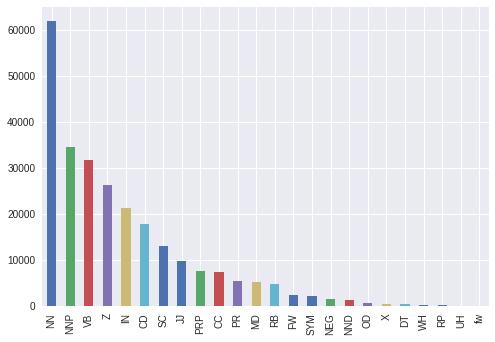

In [0]:
pt_data.tags.value_counts().plot.bar()

In [0]:
print(pt_data.tags.value_counts())
print(pt_data.tags.shape[0])

NN     61940
NNP    34649
VB     31733
Z      26347
IN     21311
CD     17819
SC     13080
JJ      9724
PRP     7583
CC      7438
PR      5348
MD      5248
RB      4903
FW      2365
SYM     2210
NEG     1520
NND     1414
OD       738
X        397
DT       381
WH       260
RP       183
UH        30
fw         1
Name: tags, dtype: int64
256622


From the visualization above, we can see that the NN has the highest number in the data.  
There is also fw that appear only once. I wonder why the label shape is 24?  
I think the author forget to uppercase the 'fw'. Let's fix  it


In [0]:
pt_data.loc[pt_data['tags'] == 'fw','tags'] = 'FW' 

## Check Numeric
We will Check are there a token that contain numeric 

In [0]:
pt_data[pt_data.tokens.str.isdigit()].shape

(5911, 2)

We will check if the token that contains numeric only

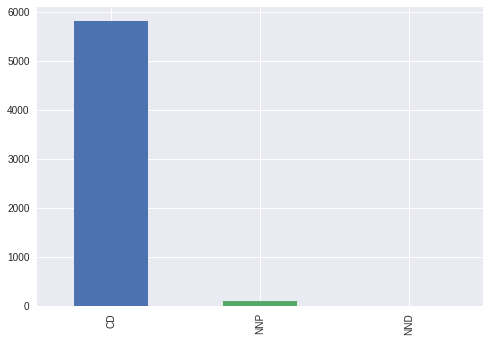

In [0]:
pt_data[pt_data.tokens.str.isdigit()]['tags'].value_counts().plot.bar()

Wow, CD is really dominant in here. So, I think , number is a feature that we must keep

## Are there any token contains '-'


In [0]:
pt_data[pt_data.tokens.str.contains('-')].shape

(7317, 2)

This much, let's see the distribution of the tags

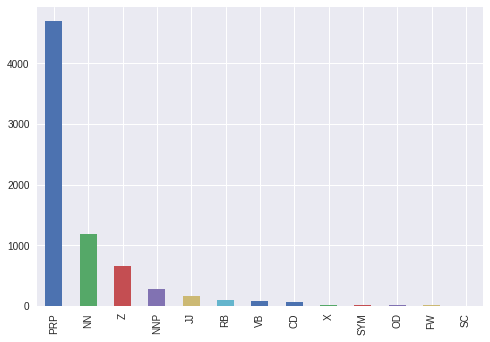

In [0]:
pt_data[pt_data.tokens.str.contains('-')]['tags'].value_counts().plot.bar()

"PRP" is the highest

## Check Length of Tokens
We need to know the lenght of the 'token' column.

In [0]:
length_pt = pt_data.tokens.apply(lambda x : len(x.split()))

In [0]:
length_pt.describe()

count    256622.000000
mean          1.020458
std           0.143095
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           4.000000
Name: tokens, dtype: float64

There are instances that contains 4 tokens on it and the mean is not 1, Lets see for each length > 1:

In [0]:
for i in range(2,5):
  print("Head:")
  print(pt_data[length_pt == i].head())
  print("Shape : {}".format(pt_data[length_pt == i].shape[0]))

Head:
    tags          tokens
3     NN  pesta olahraga
19   NNP  Pesta Olahraga
51   NNP   negara bagian
62    NN  sebagian besar
165  NNP   kantor berita
Shape : 5144
Head:
      tags                 tokens
4273    NN   daerah tujuan wisata
5216    NN  Penanaman modal asing
7148    NN    sumber daya manusia
11618   NN  penanaman modal asing
46320   NN  penanaman modal asing
Shape : 50
Head:
      tags                        tokens
14910   NN           minyak dan gas bumi
46322   NN  penanaman modal dalam negeri
Shape : 2


For this EDA, I found that:
1. There is a malformat instance in the dataset. To fix it, we need to uppercase it
2. There are some instances that have more than one tokens. 
3. Most token that contains numeric character tags are CD
3. token that contains '-' character tags dominated by PRP

# Preprocess Data and Features

In this section, I will begin on preprocess the data based on EDA that I've done.

Before we go into it, I will emphasize that I will create a model which is a feature-enginered one which is:

1. Use Logistic Regression
2. Input is a token which the feature will  be extracted in this section. Since we will use <b>a token</b>, we will split the token in the phrase which contains 2 or more tokens.
3. Output is the POS-TAG label. 

We will use these features:
1. 'token' : The token
2. 'is_first' : Is the token in the first index of the sentence
3. 'is_last' : Is the token in the last index of the sentence
4. 'is_capitalized' : is the first character in the token capitalized?
5. 'is_numeric' : is the token only contains digits ?
6. 'is_alpha' : is the token is  alphanumeric? 
6. 'prefix-1' : token prefix contains one character
7. 'prefix-2' : token prefix contains two characters
8. 'prefix-3' : token prefix contains three characters
9. 'suffix-1' : token suffix contains one character
10. 'suffix-2' : token suffix contains two characters
11. 'suffix-3' : token suffix contains three characters
12. 'prev-token' : previous token before this token
13. '2-prev-token' : second previous token before this token
14. 'next-token' : next token after this token
15. '2-next-token' : second next token after this token
16. 'contains-strip' : whether the token contains '-'
17. 'consonant' : how many consonant characters in the token
18. 'sonant' : how many sonant characters in the token


The process is as follow:


Extract the data from the tsv file

In [0]:
all_sentences = read_tsv_postag_2(file)

In [0]:
all_sentences[0:2]

[[('Kera', 'NN'),
  ('untuk', 'SC'),
  ('amankan', 'VB'),
  ('pesta', 'NN'),
  ('olahraga', 'NN')],
 [('Pemerintah', 'NNP'),
  ('kota', 'NNP'),
  ('Delhi', 'NNP'),
  ('mengerahkan', 'VB'),
  ('monyet', 'NN'),
  ('untuk', 'SC'),
  ('mengusir', 'VB'),
  ('monyet-monyet', 'NN'),
  ('lain', 'JJ'),
  ('yang', 'SC'),
  ('berbadan', 'VB'),
  ('lebih', 'RB'),
  ('kecil', 'JJ'),
  ('dari', 'IN'),
  ('arena', 'NN'),
  ('Pesta', 'NNP'),
  ('Olahraga', 'NNP'),
  ('Persemakmuran', 'NNP'),
  ('.', 'Z')]]

In [0]:
test_func_extr = extract_features('amankan',2,[('Kera', 'NN'),
  ('untuk', 'SC'),
  ('amankan', 'VB'),
  ('pesta', 'NN'),
  ('olahraga', 'NN')])

In [0]:
test_func_extr

{'2_next_token': 'olahraga',
 '2_prev_token': 'Kera',
 'consonant': 4,
 'contains_strip': False,
 'is_alphannumeric': True,
 'is_capitalized': False,
 'is_first': False,
 'is_last': False,
 'is_numeric': False,
 'next_token': 'pesta',
 'prefix_1': 'a',
 'prefix_2': 'am',
 'prefix_3': 'ama',
 'prev_token': 'untuk',
 'sonant': 3,
 'sufix_1': 'n',
 'sufix_2': 'an',
 'sufix_3': 'kan',
 'token': 'amankan'}

## Modelling
First, we will split training and test dataset (sentence). Then l will tune the parameter. with the cross validation in the training set consider the low resource of the dataset.

We will shuffle our sentence list and take 85% of it as training set and 15% as test set.  

In [0]:
seed_random = 123 # For reproducibility
np.random.seed(seed_random)
all_sentences = read_tsv_postag_2(file)
np.random.shuffle(all_sentences)

In [0]:
training_shape = int(0.85 * len(all_sentences))
training_sentences = all_sentences[:training_shape]
test_sentences = all_sentences[training_shape:]

In [42]:
len(all_sentences)

10029

We need to extract our features. We will use inbuilt function scikit-learn **DictVectorizer** to do it.


In [0]:
vectorizer = DictVectorizer()
X_train, y_train = create_data_input_output(training_sentences)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                            random_state=444, test_size=0.1)

X_test, y_test = create_data_input_output(test_sentences)
X_transform_train = vectorizer.fit_transform(X_train)
X_transform_test = vectorizer.transform(X_test)
X_transform_val = vectorizer.transform(X_val)

In [44]:
np.unique(y_train)

array(['CC', 'CD', 'DT', 'FW', 'IN', 'JJ', 'MD', 'NEG', 'NN', 'NND',
       'NNP', 'OD', 'PR', 'PRP', 'RB', 'RP', 'SC', 'SYM', 'UH', 'VB',
       'WH', 'X', 'Z'], dtype='<U3')

In [45]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(n_jobs=-1, solver='lbfgs', 
                           multi_class='multinomial', 
                           class_weight='balanced')                         
model.fit(X_transform_train, y_train) # Train model

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=-1, penalty='l2',
          random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [0]:

filename = 'log_reg.meong'
pickle.dump(model, open(filename, 'wb'))

filename_tokenizer = 'vectorizer_lr.meong'
pickle.dump(vectorizer, open(filename_tokenizer, 'wb'))

In [0]:
y_test_pred = model.predict(X_transform_test)

Accuracy : 0.9381591809435612
              precision    recall  f1-score   support

          CC     0.9558    0.9854    0.9704      1096
          CD     0.9848    0.9769    0.9808      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.5933    0.8703    0.7056       347
          IN     0.9440    0.9408    0.9424      3209
          JJ     0.7756    0.9039    0.8349      1499
          MD     0.9697    0.9783    0.9740       784
         NEG     0.9784    0.9870    0.9827       230
          NN     0.9597    0.8868    0.9218      9752
         NND     0.6942    0.9554    0.8042       202
         NNP     0.9275    0.9221    0.9248      5146
          OD     0.7170    0.9661    0.8231       118
          PR     0.9964    0.9880    0.9922       836
         PRP     0.9800    0.9912    0.9856      1139
          RB     0.8609    0.9332    0.8956       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9035    0.9422    0.9225      19

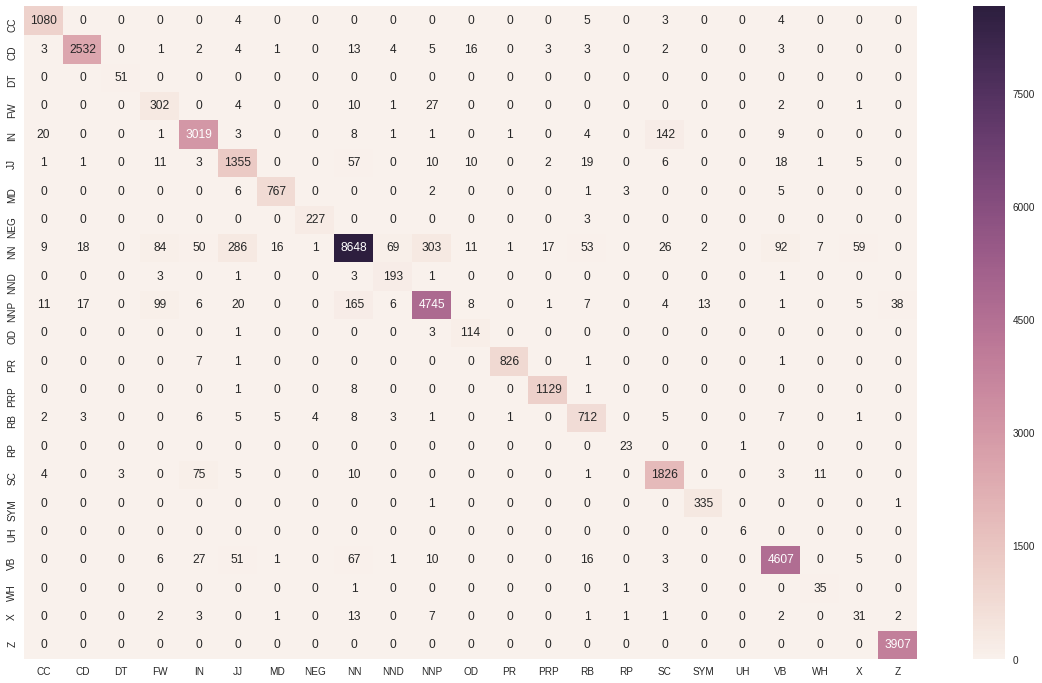

In [39]:
acc_without_ablation, class_report_ablation = print_evaluate(y_test, y_test_pred, print_conf_mat=True)

Not really overfit.. TODO explain here

## Feature Ablation

In [19]:
%%time
accs, f1_evals = ablation(training_sentences, test_sentences)

Experiment on deleting feature token


Accuracy : 0.9226218037763029
              precision    recall  f1-score   support

          CC     0.9245    0.9827    0.9527      1096
          CD     0.9692    0.9707    0.9699      2592
          DT     0.8793    1.0000    0.9358        51
          FW     0.5533    0.8530    0.6712       347
          IN     0.9374    0.9289    0.9332      3209
          JJ     0.7098    0.8679    0.7809      1499
          MD     0.9576    0.9783    0.9678       784
         NEG     0.9661    0.9913    0.9785       230
          NN     0.9594    0.8480    0.9003      9752
         NND     0.7106    0.9604    0.8168       202
         NNP     0.9215    0.9215    0.9215      5146
          OD     0.7244    0.9576    0.8248       118
          PR     0.9741    0.9892    0.9816       836
         PRP     0.9666    0.9912    0.9788      1139
          RB     0.7729    0.9056    0.8340       763
          RP     0.6765    0.9583    0.7931        24
          SC     0.8841    0.9412    0.9118      19

Accuracy : 0.9395740083346196
              precision    recall  f1-score   support

          CC     0.9525    0.9872    0.9695      1096
          CD     0.9829    0.9765    0.9797      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.5964    0.8559    0.7030       347
          IN     0.9469    0.9399    0.9434      3209
          JJ     0.7790    0.8959    0.8334      1499
          MD     0.9661    0.9821    0.9741       784
         NEG     0.9785    0.9913    0.9849       230
          NN     0.9575    0.8956    0.9255      9752
         NND     0.7751    0.9554    0.8559       202
         NNP     0.9262    0.9221    0.9241      5146
          OD     0.7012    0.9746    0.8156       118
          PR     0.9964    0.9904    0.9934       836
         PRP     0.9826    0.9903    0.9864      1139
          RB     0.8713    0.9318    0.9006       763
          RP     0.8519    0.9583    0.9020        24
          SC     0.9062    0.9422    0.9239      19

Accuracy : 0.9389309049750476
              precision    recall  f1-score   support

          CC     0.9516    0.9872    0.9691      1096
          CD     0.9825    0.9769    0.9797      2592
          DT     0.9107    1.0000    0.9533        51
          FW     0.5980    0.8530    0.7031       347
          IN     0.9416    0.9439    0.9427      3209
          JJ     0.7884    0.8999    0.8405      1499
          MD     0.9402    0.9834    0.9613       784
         NEG     0.9705    1.0000    0.9850       230
          NN     0.9605    0.8910    0.9245      9752
         NND     0.7814    0.9554    0.8597       202
         NNP     0.9248    0.9225    0.9236      5146
          OD     0.7290    0.9576    0.8278       118
          PR     0.9881    0.9916    0.9899       836
         PRP     0.9792    0.9912    0.9852      1139
          RB     0.8584    0.9292    0.8924       763
          RP     0.8519    0.9583    0.9020        24
          SC     0.9083    0.9355    0.9217      19

Accuracy : 0.9326799403200082
              precision    recall  f1-score   support

          CC     0.9616    0.9836    0.9725      1096
          CD     0.9806    0.9757    0.9781      2592
          DT     0.9107    1.0000    0.9533        51
          FW     0.5800    0.8674    0.6952       347
          IN     0.9419    0.9399    0.9409      3209
          JJ     0.7095    0.9173    0.8001      1499
          MD     0.9637    0.9821    0.9728       784
         NEG     0.9660    0.9870    0.9763       230
          NN     0.9634    0.8725    0.9157      9752
         NND     0.6457    0.9653    0.7738       202
         NNP     0.9217    0.9199    0.9208      5146
          OD     0.7233    0.9746    0.8303       118
          PR     0.9928    0.9916    0.9922       836
         PRP     0.9834    0.9912    0.9873      1139
          RB     0.8457    0.9266    0.8843       763
          RP     0.8846    0.9583    0.9200        24
          SC     0.8975    0.9396    0.9181      19

Accuracy : 0.9374131810464578
              precision    recall  f1-score   support

          CC     0.9574    0.9845    0.9708      1096
          CD     0.9829    0.9772    0.9801      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.5920    0.8530    0.6989       347
          IN     0.9405    0.9452    0.9428      3209
          JJ     0.7722    0.8999    0.8312      1499
          MD     0.9588    0.9796    0.9691       784
         NEG     0.9784    0.9826    0.9805       230
          NN     0.9595    0.8888    0.9228      9752
         NND     0.8008    0.9554    0.8713       202
         NNP     0.9234    0.9250    0.9242      5146
          OD     0.7500    0.9661    0.8444       118
          PR     0.9846    0.9928    0.9887       836
         PRP     0.9766    0.9912    0.9839      1139
          RB     0.8522    0.9292    0.8890       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9012    0.9319    0.9163      19

Accuracy : 0.9399341462159798
              precision    recall  f1-score   support

          CC     0.9541    0.9863    0.9699      1096
          CD     0.9837    0.9784    0.9810      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5833    0.8674    0.6976       347
          IN     0.9455    0.9405    0.9430      3209
          JJ     0.7785    0.9026    0.8360      1499
          MD     0.9661    0.9821    0.9741       784
         NEG     0.9784    0.9870    0.9827       230
          NN     0.9597    0.8943    0.9258      9752
         NND     0.7510    0.9554    0.8410       202
         NNP     0.9292    0.9207    0.9249      5146
          OD     0.7188    0.9746    0.8273       118
          PR     0.9869    0.9928    0.9899       836
         PRP     0.9792    0.9912    0.9852      1139
          RB     0.8764    0.9292    0.9020       763
          RP     0.8846    0.9583    0.9200        24
          SC     0.9091    0.9396    0.9241      19

Accuracy : 0.9368729742244174
              precision    recall  f1-score   support

          CC     0.9633    0.9808    0.9720      1096
          CD     0.9814    0.9745    0.9779      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.5959    0.8415    0.6977       347
          IN     0.9466    0.9392    0.9429      3209
          JJ     0.7782    0.8966    0.8332      1499
          MD     0.9650    0.9847    0.9747       784
         NEG     0.9705    1.0000    0.9850       230
          NN     0.9588    0.8899    0.9230      9752
         NND     0.7148    0.9554    0.8178       202
         NNP     0.9254    0.9229    0.9241      5146
          OD     0.7188    0.9746    0.8273       118
          PR     0.9893    0.9940    0.9916       836
         PRP     0.9750    0.9912    0.9830      1139
          RB     0.8501    0.9214    0.8843       763
          RP     0.8846    0.9583    0.9200        24
          SC     0.8944    0.9355    0.9145      19

Accuracy : 0.9357925605803364
              precision    recall  f1-score   support

          CC     0.9625    0.9827    0.9725      1096
          CD     0.9837    0.9757    0.9797      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5960    0.8674    0.7066       347
          IN     0.9453    0.9423    0.9438      3209
          JJ     0.7748    0.8953    0.8307      1499
          MD     0.9335    0.9847    0.9584       784
         NEG     0.9664    1.0000    0.9829       230
          NN     0.9600    0.8828    0.9198      9752
         NND     0.7608    0.9604    0.8490       202
         NNP     0.9212    0.9265    0.9239      5146
          OD     0.7261    0.9661    0.8291       118
          PR     0.9835    0.9952    0.9893       836
         PRP     0.9666    0.9912    0.9788      1139
          RB     0.8217    0.9240    0.8698       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9050    0.9391    0.9218      19

Accuracy : 0.9319082162885219
              precision    recall  f1-score   support

          CC     0.9582    0.9827    0.9703      1096
          CD     0.9787    0.9745    0.9766      2592
          DT     0.8793    1.0000    0.9358        51
          FW     0.5435    0.8646    0.6674       347
          IN     0.9419    0.9405    0.9412      3209
          JJ     0.7693    0.8899    0.8252      1499
          MD     0.9647    0.9758    0.9702       784
         NEG     0.9534    0.9783    0.9657       230
          NN     0.9549    0.8792    0.9155      9752
         NND     0.6655    0.9653    0.7879       202
         NNP     0.9286    0.9143    0.9214      5146
          OD     0.7170    0.9661    0.8231       118
          PR     0.9776    0.9928    0.9852       836
         PRP     0.9683    0.9912    0.9796      1139
          RB     0.8434    0.9174    0.8788       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9009    0.9340    0.9172      19

Accuracy : 0.9389823532438133
              precision    recall  f1-score   support

          CC     0.9617    0.9845    0.9729      1096
          CD     0.9807    0.9788    0.9797      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5669    0.8790    0.6893       347
          IN     0.9416    0.9452    0.9434      3209
          JJ     0.8046    0.8873    0.8439      1499
          MD     0.9601    0.9821    0.9710       784
         NEG     0.9617    0.9826    0.9720       230
          NN     0.9555    0.8947    0.9241      9752
         NND     0.7106    0.9604    0.8168       202
         NNP     0.9267    0.9184    0.9225      5146
          OD     0.7261    0.9661    0.8291       118
          PR     0.9976    0.9916    0.9946       836
         PRP     0.9809    0.9912    0.9860      1139
          RB     0.8376    0.9332    0.8828       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9118    0.9340    0.9228      19

Accuracy : 0.9375160775839892
              precision    recall  f1-score   support

          CC     0.9642    0.9827    0.9733      1096
          CD     0.9807    0.9803    0.9805      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5788    0.8357    0.6840       347
          IN     0.9446    0.9405    0.9425      3209
          JJ     0.7881    0.8906    0.8362      1499
          MD     0.9648    0.9796    0.9722       784
         NEG     0.9623    1.0000    0.9808       230
          NN     0.9582    0.8879    0.9217      9752
         NND     0.7212    0.9604    0.8238       202
         NNP     0.9224    0.9238    0.9231      5146
          OD     0.7290    0.9576    0.8278       118
          PR     0.9881    0.9940    0.9911       836
         PRP     0.9860    0.9912    0.9886      1139
          RB     0.8461    0.9292    0.8857       763
          RP     0.8519    0.9583    0.9020        24
          SC     0.9017    0.9376    0.9193      19

Accuracy : 0.9302618716880177
              precision    recall  f1-score   support

          CC     0.9457    0.9845    0.9647      1096
          CD     0.9771    0.9726    0.9749      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.5339    0.8386    0.6525       347
          IN     0.9388    0.9464    0.9426      3209
          JJ     0.7453    0.8786    0.8065      1499
          MD     0.9528    0.9783    0.9654       784
         NEG     0.9456    0.9826    0.9638       230
          NN     0.9528    0.8712    0.9102      9752
         NND     0.6522    0.9653    0.7784       202
         NNP     0.9241    0.9197    0.9219      5146
          OD     0.7261    0.9661    0.8291       118
          PR     0.9893    0.9916    0.9904       836
         PRP     0.9886    0.9912    0.9899      1139
          RB     0.8105    0.9135    0.8589       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9011    0.9314    0.9160      19

Accuracy : 0.9304933888974636
              precision    recall  f1-score   support

          CC     0.9557    0.9836    0.9694      1096
          CD     0.9825    0.9722    0.9773      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5820    0.8386    0.6871       347
          IN     0.9343    0.9392    0.9368      3209
          JJ     0.7467    0.8793    0.8076      1499
          MD     0.9468    0.9770    0.9617       784
         NEG     0.9583    1.0000    0.9787       230
          NN     0.9560    0.8697    0.9108      9752
         NND     0.6993    0.9554    0.8075       202
         NNP     0.9186    0.9227    0.9206      5146
          OD     0.6905    0.9831    0.8112       118
          PR     0.9845    0.9904    0.9875       836
         PRP     0.9792    0.9912    0.9852      1139
          RB     0.8444    0.9174    0.8794       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.8999    0.9319    0.9156      19

Accuracy : 0.9376704223902865
              precision    recall  f1-score   support

          CC     0.9608    0.9845    0.9725      1096
          CD     0.9802    0.9745    0.9774      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5695    0.8501    0.6821       347
          IN     0.9454    0.9445    0.9450      3209
          JJ     0.7787    0.8993    0.8347      1499
          MD     0.9636    0.9783    0.9709       784
         NEG     0.9664    1.0000    0.9829       230
          NN     0.9594    0.8884    0.9225      9752
         NND     0.7628    0.9554    0.8484       202
         NNP     0.9233    0.9221    0.9227      5146
          OD     0.6826    0.9661    0.8000       118
          PR     0.9846    0.9940    0.9893       836
         PRP     0.9783    0.9912    0.9847      1139
          RB     0.8716    0.9253    0.8976       763
          RP     0.8519    0.9583    0.9020        24
          SC     0.9083    0.9350    0.9214      19

Accuracy : 0.9339404229047693
              precision    recall  f1-score   support

          CC     0.9633    0.9818    0.9724      1096
          CD     0.9774    0.9688    0.9731      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5786    0.8588    0.6914       347
          IN     0.9281    0.9411    0.9346      3209
          JJ     0.7680    0.8899    0.8245      1499
          MD     0.9624    0.9783    0.9703       784
         NEG     0.9623    1.0000    0.9808       230
          NN     0.9604    0.8835    0.9204      9752
         NND     0.7283    0.9554    0.8266       202
         NNP     0.9211    0.9209    0.9210      5146
          OD     0.6686    0.9746    0.7931       118
          PR     0.9810    0.9868    0.9839       836
         PRP     0.9716    0.9912    0.9813      1139
          RB     0.8413    0.9174    0.8777       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.8999    0.9319    0.9156      19

Accuracy : 0.9394196635283223
              precision    recall  f1-score   support

          CC     0.9483    0.9872    0.9674      1096
          CD     0.9848    0.9757    0.9802      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5929    0.8646    0.7034       347
          IN     0.9457    0.9439    0.9448      3209
          JJ     0.7691    0.8979    0.8286      1499
          MD     0.9472    0.9847    0.9656       784
         NEG     0.9705    1.0000    0.9850       230
          NN     0.9603    0.8903    0.9240      9752
         NND     0.7311    0.9554    0.8283       202
         NNP     0.9233    0.9246    0.9240      5146
          OD     0.7170    0.9661    0.8231       118
          PR     0.9870    0.9952    0.9911       836
         PRP     0.9800    0.9912    0.9856      1139
          RB     0.9057    0.9318    0.9186       763
          RP     0.8846    0.9583    0.9200        24
          SC     0.9126    0.9324    0.9224      19

Accuracy : 0.9361526984616968
              precision    recall  f1-score   support

          CC     0.9668    0.9818    0.9742      1096
          CD     0.9806    0.9769    0.9787      2592
          DT     0.9273    1.0000    0.9623        51
          FW     0.5803    0.8646    0.6944       347
          IN     0.9388    0.9464    0.9426      3209
          JJ     0.7552    0.9013    0.8218      1499
          MD     0.9660    0.9770    0.9715       784
         NEG     0.9745    0.9957    0.9849       230
          NN     0.9620    0.8811    0.9198      9752
         NND     0.7405    0.9604    0.8362       202
         NNP     0.9314    0.9178    0.9245      5146
          OD     0.7055    0.9746    0.8185       118
          PR     0.9857    0.9916    0.9887       836
         PRP     0.9758    0.9912    0.9834      1139
          RB     0.8527    0.9332    0.8911       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9083    0.9355    0.9217      19

Accuracy : 0.9521016617790812
              precision    recall  f1-score   support

          CC     0.9695    0.9863    0.9778      1096
          CD     0.9888    0.9846    0.9867      2592
          DT     0.9444    1.0000    0.9714        51
          FW     0.6682    0.8588    0.7516       347
          IN     0.9470    0.9523    0.9497      3209
          JJ     0.8527    0.9113    0.8810      1499
          MD     0.9833    0.9745    0.9789       784
         NEG     0.9784    0.9826    0.9805       230
          NN     0.9651    0.9223    0.9432      9752
         NND     0.8042    0.9554    0.8733       202
         NNP     0.9298    0.9366    0.9332      5146
          OD     0.7986    0.9746    0.8779       118
          PR     0.9952    0.9964    0.9958       836
         PRP     0.9844    0.9991    0.9917      1139
          RB     0.9182    0.9410    0.9294       763
          RP     0.8214    0.9583    0.8846        24
          SC     0.9183    0.9396    0.9288      19

Accuracy : 0.9448731800174924
              precision    recall  f1-score   support

          CC     0.9474    0.9863    0.9665      1096
          CD     0.9872    0.9788    0.9830      2592
          DT     0.8793    1.0000    0.9358        51
          FW     0.6168    0.8674    0.7210       347
          IN     0.9563    0.9352    0.9456      3209
          JJ     0.8143    0.9039    0.8568      1499
          MD     0.9759    0.9809    0.9784       784
         NEG     0.9702    0.9913    0.9806       230
          NN     0.9626    0.9055    0.9332      9752
         NND     0.7659    0.9554    0.8502       202
         NNP     0.9266    0.9267    0.9266      5146
          OD     0.7325    0.9746    0.8364       118
          PR     0.9940    0.9952    0.9946       836
         PRP     0.9726    0.9974    0.9848      1139
          RB     0.8959    0.9358    0.9154       763
          RP     0.8846    0.9583    0.9200        24
          SC     0.8995    0.9556    0.9267      19

Collected: 
    

In [0]:
f1_micro = [micro_f1['micro avg']['f1-score'] for micro_f1 in f1_evals]
f1_macro = [micro_f1['macro avg']['f1-score'] for micro_f1 in f1_evals]


In [44]:
len(accs),len(f1_micro),len(features)

(20, 19, 20)

## Result of Feature Ablation

In [0]:
accs = accs[:-1]
features = features[:-1]

In [46]:
features = ['token','is_first', 'is_last', 'is_capitalized', 'is_numeric', 
            'is_alphannumeric', 'prefix_1', 'prefix_2', 'prefix_3',
            'sufix_1','sufix_2','sufix_3','prev_token','2_prev_token',
            'next_token','2_next_token','contains_strip','consonant','sonant']
features.append("None")
accs.append(acc_without_ablation)
f1_micro.append(class_report_ablation['micro avg']['f1-score'])
f1_macro.append(class_report_ablation['macro avg']['f1-score'])

pd.DataFrame({'feature ablation' : features, 'acc_score' : accs, 
              'f1_micro' : f1_micro, 'f1_macro' : f1_macro})

,acc_score,f1_macro,f1_micro,feature ablation
0,0.922622,0.866731,0.922622,token
1,0.939574,0.894773,0.939574,is_first
2,0.938931,0.890985,0.938931,is_last
3,0.932680,0.880002,0.932680,is_capitalized
4,0.937413,0.889972,0.937413,is_numeric
5,0.939934,0.896507,0.939934,is_alphannumeric
6,0.936873,0.877949,0.936873,prefix_1
7,0.935793,0.876961,0.935793,prefix_2
8,0.931908,0.875185,0.931908,prefix_3
9,0.938982,0.883377,0.938982,sufix_1


After doing feature ablation on the models, we know that :
1. Feature 'token' is important to the model. If we remove it, there will be a significant drop to the quality of the model.
2. Feature 'sufix_3','prefix_3','prefix_2', 'prev_token', '2_prev_token', 'next_token' also has a slightly drop if the feature is removed. This can inditate that the previous word  is important as the predictor of the postag. The prefix and sufix also helps a bit.
3. If we remove the 'consonant' or 'sonant' feature , the model's quality is improved. This indicates that this feature make our model's quality drop. 
4. The other features other than mentioned above do not have significant influence on the model's quality.

# Error Analysis
After we do feature ablation, we need to know what the model cannot predict. We will convert them into dataframe of : Token, Y_true, Y_predict  
We will see the true negative and true positive

In [0]:
tokens = []

for sentence in test_sentences:
  for token in sentence:
    tokens.append(token[0])

In [57]:
len(tokens) == len(y_test)

True

In [0]:
model = pickle.load( open( "log_reg.sav", "rb" ) )

In [0]:
X_test, y_test = create_data_input_output(test_sentences)
X_transform_test = vectorizer.transform(X_test)
y_test_pred = model.predict(X_transform_test)

In [0]:
df_test_pred = pd.DataFrame({'tokens' : tokens, 'y_true' : y_test, 'y_pred' : y_test_pred})

# How do I do error analysis?

I will sample some false negative , false positive, and true positive for each tags. This way, I  know what case the model cannot predict

In [0]:
unique_tags = df_test_pred.y_true.unique()

In [0]:
%matplotlib inline

In [64]:
def show_example_sample_df(df, df_all, sample=7, max_tokens=6):
  if df.shape[0] == 0:
    print("None")
  else:
    df = df.sample(min(sample,df.shape[0]))
    display(df)
    for i,tok in df.iterrows():
      display(' '.join(df_all.iloc[i-max_tokens:i+max_tokens].tokens))

for tag in unique_tags:
  display(HTML("<h1>{}</h1>".format(tag)))
  print("True Positive of tag {}".format(tag))
  df_tp = df_test_pred[(df_test_pred.y_true == tag) & (df_test_pred.y_pred == tag)]
  show_example_sample_df(df_tp, df_test_pred)
  
  print("False Negative of tag {}".format(tag))
  df_fn = df_test_pred[(df_test_pred.y_true == tag) & (df_test_pred.y_pred != tag)]
  print("Distribution of y_pred")
  display(df_fn.y_pred.value_counts())
  show_example_sample_df(df_fn, df_test_pred)

  print("False Positive of tag {}".format(tag))
  df_fp = df_test_pred[(df_test_pred.y_true != tag) & (df_test_pred.y_pred == tag)]
  print("Distribution of y_true")
  print(df_fp.y_true.value_counts())
  show_example_sample_df(df_fp, df_test_pred)
 


True Positive of tag SC


,tokens,y_pred,y_true
28235,yang,SC,SC
28251,dengan,SC,SC
25055,yang,SC,SC
1790,karena,SC,SC
19025,yang,SC,SC
30767,sebelumnya,SC,SC
25491,sementara,SC,SC


'hasil konkret , kata Erdogan , yang mengatakan situasi Irak kini menjadi'

'yang lebih besar bagi Turki dibanding dengan usaha mereka menjadi anggota Uni'

'cukup tinggi itu merupakan pola tahunan yang juga terjadi pada tahun sebelum'

'berada di bawah bulan Februari , karena kita lihat kemarin ada kenaikan'

'pada 2 Februari . Lingkup jasa yang diberikan mencakup kegiatan-kegiatan spesifik sektor'

'yang melakukan intervensi melihat posisi rupiah sebelumnya terpuruk . Tahun depan mungkin'

'APBN - P 2008 . Angka sementara NPI pada kuartal kedua 2007'

False Negative of tag SC
Distribution of y_pred


IN    75
WH    11
NN    10
JJ     5
CC     4
DT     3
VB     3
RB     1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
13439,dengan,IN,SC
22973,Dengan,IN,SC
10446,dengan,IN,SC
29571,dengan,IN,SC
36335,untuk,IN,SC
3368,dengan,IN,SC
10662,dengan,IN,SC


'setelah pembunuhan besar-besaran pada Senin lalu dengan korban sedikit -nya 100 orang'

'Bejarano , pemimpin paramiliter Medellin . Dengan telah dihentikan -nya kucuran kredit'

'bebas . APBNP 2007 akan ditutup dengan defisit sebesar Rp 49,5 triliun'

'sana , kata -nya . Sampai dengan saat ini , ekspansi kredit'

'9 per dolar AS , namun untuk menuju ke arah sana dinilai'

'triliun . Beberapa sumber yang dekat dengan Abbas mengatakan , ia tampaknya'

'sebulan . Suatu tabrakan kereta api dengan truk trailer Kamis pagi di'

False Positive of tag SC
Distribution of y_true
IN     142
NN      26
JJ       6
RB       5
NNP      4
VB       3
CC       3
WH       3
CD       2
X        1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
11103,untuk,SC,IN
18324,untuk,SC,IN
12626,dengan,SC,IN
19006,agama,SC,NN
34233,sampai,SC,IN
20338,seberapa,SC,X
30068,sampai,SC,IN


'Jumat , mengemukakan Tyson akan diadili untuk dua pelanggaran yaitu memiliki obat'

"persen . Mereka tetap akan berusaha untuk ' survive ' dengan cara"

'hanya sebesar 37,4 persen dari PDB dengan kapitalisasi Rp 1.250 triliun .'

'berusia 30 tahun yang telah memeluk agama Islam itu ditangkap di kota'

'menetapkan undang-undang membolehkan penahanan tersangka teroris sampai 90 hari seperti negara asal'

'. Bahkan masalah sederhana , seperti seberapa sering keluarga makan bersama dan'

'Parung . Namun acara itu ditunda sampai Selasa pagi , di tengah'

True Positive of tag PR


,tokens,y_pred,y_true
29618,itu,PR,PR
15236,tersebut,PR,PR
4336,itu,PR,PR
6210,itu,PR,PR
27465,itu,PR,PR
648,itu,PR,PR
36924,tersebut,PR,PR


'AS , namun mata uang Indonesia itu tertahan oleh gejolak ekonomi global'

'mengatakan , hal-hal yang mendorong pertumbuhan tersebut , antara lain investasi yang'

'Kemudian salah seorang dari tiga bersaudara itu mengikuti seruan dari teman -nya'

'terus-menerus kelebihan berat tubuh . Angka itu sudah jauh terlampaui jika dibanding'

'memperoleh pembiayaan dari kesepakatan tersebut Sementara itu Meneg PPN / Kepala Bappenas'

'ini bisa dikatakan berhasil , keberhasilan itu adalah mendorong perdebatan mengenai apa'

'Baghdad menjelang perebutan ibu kota Irak tersebut . Sebaliknya pemerintah Indonesia harus'

False Negative of tag PR
Distribution of y_pred


IN    7
JJ    1
VB    1
RB    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
19098,di,IN,PR
37403,di,IN,PR
30968,ke,IN,PR
6924,tertentu,JJ,PR
37109,di,IN,PR
36118,tadi,VB,PR
5849,di,IN,PR


'-nya . Penempatan kelompok tempur kedua di sini adalah untuk membantu operasi'

'persen . Nazarbayev , yang tiba di sini kemarin , juga mengadakan'

'Kamis . Ia tak kan datang ke sini untuk berdoa mengenai gaya'

'pendengki dan gerakan-gerakan jahat dari kekuatan-kekuatan tertentu sejak kemenangan revolusi besar Iran'

'ke Kirkuk waktu pertama kali dan di sana kebetulan ada Jenderal Odierno'

'tersebut dinilai sangat stabil . Pembahasan tadi masih dalam tahap awal .'

'cuaca adalah sesuatu yang memang ada di sini dan sekarang bukan bagi'

False Positive of tag PR
Distribution of y_true
NN    1
IN    1
RB    1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
13923,ini,PR,RB
6699,di,PR,IN
38756,sandi,PR,NN


'mulai menjadi kaya dan kami baru-baru ini saja bisa memberi makan diri'

'kata juru bicara kementerian luar negeri di sini Selasa . Tambahan anggaran'

'jalur partai utama . Penyerbuan-penyerbuan dengan sandi Operasi Spartacus itu , yang'

True Positive of tag Z


,tokens,y_pred,y_true
23016,",",Z,Z
34943,.,Z,Z
38092,.,Z,Z
21989,",",Z,Z
20711,.,Z,Z
32231,),Z,Z
19368,.,Z,Z


', itu cukup bagus dan reasonable , kata Deputi Gubernur BI ,'

'dan dituntut hukuman tujuh bulan penjara . Kita harus memperlambat -nya .'

'itu memasuki tubuh -nya secara alamiah . Namun , kata Pefindo ,'

'adalah di sektor perdagangan , restoran , dan hotel mencapai Rp 579,41'

'apa pengaturan -nya , kata Abrun . Inflasi tersebut dipicu meningkat -nya'

'militer , tempat Conte ( 72 ) , yang pertama kali memangku'

'. Benar-benar tergantung pada beberapa suara . Maju mundur dan akhirnya Amanda'

False Negative of tag Z
Distribution of y_pred


Series([], Name: y_pred, dtype: int64)

None
False Positive of tag Z
Distribution of y_true
NNP    38
X       2
SYM     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
34163,-,Z,NNP
33328,-,Z,NNP
14978,-,Z,NNP
19826,-,Z,X
8712,-,Z,NNP
36512,-,Z,NNP
21353,-,Z,NNP


'Menteri pertahanan Korea Selatan Yoon Kwang - Ung menawarkan pembentukan kontak langsung'

'. Ia mengatakan ribuan simpatisan As - Sadr sedang dalam perjalanan ke'

'-nya . Di samping itu Bapepam - LK telah melakukan pemeriksaan terhadap'

'pegiat Palestina dari rumah - ke - rumah . Beberapa penumpang mengalami'

'. Ketua PBB , Ban Ki - Moon , Senin menyerukan Israel'

', Jumat . Pembelian saham Mobile - 8 tersebut dilakukan pada periode'

'penjualan yang masuk ke kas PDI - Perjuangan untuk pemenangan pemilu pada'

True Positive of tag NN


,tokens,y_pred,y_true
21676,pagi,NN,NN
4905,aktivis,NN,NN
17884,APBNP,NN,NN
7336,pasar,NN,NN
34308,kendaraan,NN,NN
23615,gas,NN,NN
11204,nasib,NN,NN


'tiga orang yang tewas dalam serangan pagi ini di perbatasan dengan Ghana'

'agar melakukan tindakan lebih keras terhadap aktivis garis keras di wilayah -nya'

'asumsi nilai tukar dari usulan awal APBNP 2007 Rp 9.100 per dolar'

'kepada pasar keuangan untuk meningkatkan kepercayaan pasar terhadap stabilitas sistem keuangan dan'

'satuan penyamar Israel . Paktiawal menyatakan kendaraan sasaran itu bukan mobil tentara'

'perumahan , air , listrik , gas , dan bahan bakar 1,58'

'orang rekan mereka masih belum diketahui nasib -nya . Hizbullah menerima bantuan'

False Negative of tag NN
Distribution of y_pred


NNP    303
JJ     286
VB      92
FW      84
NND     69
X       59
RB      53
IN      50
SC      26
CD      18
PRP     17
MD      16
OD      11
CC       9
WH       7
SYM      2
PR       1
NEG      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
28208,tubuh,JJ,NN
32885,masalah-masalah,CD,NN
37750,Modul,NNP,NN
8816,syarat-syarat,X,NN
9803,sendiri,PRP,NN
37172,pantai,JJ,NN
27782,runding,FW,NN


'beralih kepada operasi untuk mengurangi berat tubuh dan peningkatan jumlah pemuda yang'

'Shangkahi ( SCO ) , dan masalah-masalah regional dan internasional lain -nya'

'persen dari laba bersih 2006 . Modul Pelaporan Online Ditjen Bea dan'

'kata -nya . Dalam rangka mempermudah syarat-syarat permohonan visa , Jepang juga'

'ini tentu -nya mustahil karena inflasi sendiri hanya lah sebuah fenomena ,'

'yang disalurkan terus meningkat . Kawasan pantai selatan Iran menghampar memasuki Teluk'

'sarapan ulang tahun kepada kepala juru runding Korsel , Lee , yang'

False Positive of tag NN
Distribution of y_true
NNP    165
VB      67
JJ      57
CD      13
X       13
FW      10
SC      10
RB       8
IN       8
PRP      8
NND      3
WH       1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
1036,via,NN,IN
37183,Dahlan,NN,NNP
20563,tangan,NN,JJ
4587,indonesia,NN,NNP
8134,PPh,NN,NNP
14999,pipanisasi,NN,X
30868,kontra,NN,JJ


'kartu dan mesin ATM , seperti via kliring , real time gross'

'Teluk Oman dan Laut Arab . Dahlan seorang pengkhianat , teriak mereka'

'mencari korban di reruntuhan bangunan dengan tangan terbuka dan sekop . Mereka'

'selalu berusaha membuat -nya lebih menguntungkan indonesia . Oleh karena itu ,'

'per ton . Anggota Panja RUU PPh Dradjat Wibowo , di Jakarta'

'pelaksana proyek dan manajer proyek komersialisasi pipanisasi SSWJ . Sekitar separuh dari'

'pusat kota Minsk . Pro dan kontra menyangkut opsi yang akan diambil'

True Positive of tag NNP


,tokens,y_pred,y_true
28249,Turki,NNP,NNP
18451,Dunia,NNP,NNP
17911,Bush,NNP,NNP
7226,Indonesia,NNP,NNP
8330,Selasa,NNP,NNP
6798,Retail,NNP,NNP
17801,Senin,NNP,NNP


'luar negeri yang lebih besar bagi Turki dibanding dengan usaha mereka menjadi'

'2006 . Dijelaskan -nya , Bank Dunia saat ini tengah berusaha membuat'

'masih bekerja di dunia , kata Bush , mengacu pada serangan 9'

'Analis Citi Corp memperkirakan pertumbuhan ekonomi Indonesia pada 2008 sebesar enam persen'

', kata -nya di Jakarta , Selasa . Fraksi PAN , melalui'

'mengakibatkan rupiah terpuruk , kata Direktur Retail Banking PT Bank Mega Tbk'

', kata Boediono di Jakarta , Senin . Tentu saja , ada'

False Negative of tag NNP
Distribution of y_pred


NN     165
FW      99
Z       38
JJ      20
CD      17
SYM     13
CC      11
OD       8
RB       7
NND      6
IN       6
X        5
SC       4
VB       1
PRP      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
29295,partai,NN,NNP
8250,First,FW,NNP
13570,Forest,FW,NNP
5682,130,CD,NNP
36697,Obligasi,NND,NNP
34038,BTPN,NN,NNP
23969,berita,VB,NNP


'menanggapi pertanyaan survei tersebut ; pendukung partai Demokrat lebih ragu mengenai keterangan'

'teknologi pengolahan pyrometallurgy dan hydrometallurgy . First Islamic Investment Bank Ltd .'

'syarat Indonesia melakukan pembayaran kepada Tropical Forest Fund yang kemudian akan menggunakan'

'-nya mengatakan , pesawat AC - 130 bersenjata itu melakukan operasi dalam'

'memberikan peringkat idAA- untuk rencana penerbitan Obligasi VIII / 2007 sebesar maksimum'

'seperti yang diusulkan sejumlah pihak . BTPN didirikan pada 1958 di bawah'

'-nya tidak disebutkan , kepada kantor berita Inggris Reuters . Karena kita'

False Positive of tag NNP
Distribution of y_true
NN     303
FW      27
JJ      10
VB      10
X        7
CD       5
OD       3
MD       2
RB       1
NND      1
SYM      1
IN       1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
19165,Bantuan,NNP,NN
3246,EPA,NNP,FW
4882,SLA,NNP,FW
17140,Perekonomian,NNP,NN
13774,kota,NNP,NN
20871,Sekretaris,NNP,NN
31917,Pengadilan,NNP,NN


'2007 tidak ada dana tersebut . Bantuan Uni Eropa ( EU )'

'MW , dan economic partnership agreement EPA . Pembagian dividen tersebut telah'

'di dalam Naskah Perjanjian Penerusan Pinjaman SLA . Wakil Presiden AS Dick'

'alokasi dana dekonsentrasi , kata Menko Perekonomian , APBN 2007 secara khusus'

'bentrokan di Baghdad dan Mosul , kota bagian utara Irak , kata'

'Rp 23 per saham , kata Sekretaris Polisi mengatakan , motif pria'

'polisi tersebut dilakukan tanpa mematuhi perintah Pengadilan Tinggi yang memutuskan bahwa pawai'

True Positive of tag CC


,tokens,y_pred,y_true
37415,serta,CC,CC
22626,dan,CC,CC
21947,dan,CC,CC
5011,kemudian,CC,CC
34106,serta,CC,CC
37450,tapi,CC,CC
20455,dan,CC,CC


'pembicaraan dengan Presiden Mesir Husni Mubarak serta para pemimpin Mesir lain -nya'

'ini menyarikan isu di bidang pengaturan dan pengawasan yang berkembang di dunia'

', jelas -nya . Selandia Baru dan Australia telah mengutuk kudeta yang'

'lahir pada 22 November 1892 , kemudian disusul warga Jepang Yone Minagawa'

'memulai dengan membuat rencana kerja pemerintah serta melihat proyeksi tahun 2007 yang'

'katakan tak meliputi warga sipil , tapi belum ada seorang pun di'

'hak asasi manusia , termasuk penculikan dan penyiksaan , oleh kelompok-kelompok non'

False Negative of tag CC
Distribution of y_pred


RB    5
JJ    4
VB    4
SC    3
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
36617,baik,JJ,CC
36926,Sebaliknya,RB,CC
7130,baik,JJ,CC
13478,kecuali,VB,CC
38683,Adapun,SC,CC
24127,kecuali,VB,CC
20364,Sementara,SC,CC


'undangan kepada 11 calon agen penjual baik dari dalam negeri local institutions'

'perebutan ibu kota Irak tersebut . Sebaliknya pemerintah Indonesia harus membayar cicilan'

'. Kita akan ambil dari sumber-sumber baik dari dalam negeri maupun luar'

'enggan berhadapan langsung dengan milisi , kecuali mereka diserang . Semoga saja'

'lah berbagai bantuan kepada mereka . Adapun Martinovich - yang sempat disebut'

'untuk melakukan pengayaan nuklir -nya , kecuali di bawah pengawasan Badan Energi'

'tubuh anak-anak , kata -nya . Sementara laba usaha perseroan dalam periode'

False Positive of tag CC
Distribution of y_true
IN     20
NNP    11
NN      9
SC      4
CD      3
RB      2
JJ      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
10134,Sebagian,CC,CD
9200,dan,CC,NNP
31597,dan,CC,NNP
22675,Selain,CC,IN
17133,Selain,CC,IN
6331,seakan,CC,SC
10661,api,CC,NN


'dan Jepang , kata -nya . Sebagian donor akan tampaknya menghubungkan tawaran'

'Komite Tetap Kadin Indonesia Bidang Moneter dan Fiskal , Bambang Soesatyo ,'

'dengan mobilitas terbatas dari Menteri Komunikasi dan Informatika Menkominfo kepada tiga anak'

'perang Irak yang tidak populer . Selain itu , lembaga donor ini'

'cukup aman , kata -nya . Selain alokasi dana dekonsentrasi , kata'

'membuat kita jatuh tersungkur , bahkan seakan berada di titik nadir .'

'% sebulan . Suatu tabrakan kereta api dengan truk trailer Kamis pagi'

True Positive of tag VB


,tokens,y_pred,y_true
4193,mencoba,VB,VB
11439,berasal,VB,VB
37479,memproduksi,VB,VB
1514,menghubungkan,VB,VB
29361,kembali,VB,VB
24729,disandera,VB,VB
18830,ditingkatkan,VB,VB


'Timur Tengah ( Timteng ) untuk mencoba menghidupkan kembali proses perdamaian .'

'pertama , menurun -nya risiko yang berasal dari global growth atau pertumbuhan'

'yang menurut mereka hanya dimaksudkan untuk memproduksi listrik . Tim itu ,'

', termasuk jalan raya utama yang menghubungkan Lembah Kashmir yang disengketakan ,'

'pengeboman itu dan akan segera dibuka kembali . Kami melihat pasar terlebih'

', jumlah warga asing yang kini disandera di kawasan penghasil minyak Nigeria'

'Dengan teknologi hybrida produksi rata-rata bisa ditingkatkan dari 4 ton per ha'

False Negative of tag VB
Distribution of y_pred


NN     67
JJ     51
IN     27
RB     16
NNP    10
FW      6
X       5
SC      3
NND     1
MD      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
23047,Nampak,NN,VB
17541,fasilitasi,NN,VB
9023,bersama,IN,VB
13617,bahu-membahu,RB,VB
5891,mati,NN,VB
26119,alih,NN,VB
20939,terpencil,JJ,VB


'harga Rp 166 per saham . Nampak jelas , untuk melayani pengusaha'

'Program . Menurut Rochadi , tim fasilitasi ini bertugas untuk mendorong fungsi'

'ketika memberikan sambutan dalam acara sarasehan bersama pimpinan redaksi media massa di'

'Bank , seperti ditulis Stiglitz , bahu-membahu mengusung neoliberalisme dan neokolonialisme di'

'berwenang lokal bidang transportasi , ditembak mati saat sedang mengendarai motor untuk'

'sebesar 700 miliar dolar untuk mengambil alih kredit macet yang menggunung pada'

'asing ditawan kelompok bersenjata di rawa terpencil Delta Niger , daerah sumber'

False Positive of tag VB
Distribution of y_true
NN     92
JJ     18
IN      9
RB      7
MD      5
CC      4
CD      3
SC      3
X       2
FW      2
PR      1
NND     1
NNP     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
22770,tadi,VB,NN
9994,bekas,VB,NN
25921,melalui,VB,IN
6323,dimensi,VB,NN
37073,berencana,VB,NN
23969,berita,VB,NNP
30136,dialog,VB,NN


'sekitar 100 dolar per barel , tadi malam 97 dolar . Kenaikan'

'-nya dengan membeli kapal baru atau bekas untuk jumlah senilai 500 juta'

'kuat dalam sektor perdagangan . Setelah melalui proses diskusi dan pertimbangan yang'

'terus merosot . Dihantam krisis multi dimensi , membuat kita jatuh tersungkur'

'ia dipandang melanggar kebijakan ketat keluarga berencana , demikian laporan satu surat'

'-nya tidak disebutkan , kepada kantor berita Inggris Reuters . Karena kita'

"pertama dari perundingan-perundingan dalam rangkaian ' dialog strategis . ' Menurut Kostaman"

True Positive of tag IN


,tokens,y_pred,y_true
26958,ke,IN,IN
19014,di,IN,IN
31077,di,IN,IN
27002,dengan,IN,IN
19790,dengan,IN,IN
14833,bagi,IN,IN
27512,hingga,IN,IN


'Pakistan , Khursheed Mehmood Kasuri bertolak ke New Delhi untuk melakukan perundingan'

'itu ditangkap di kota Raiwind Pakistan di dekat perbatasan dengan India pada'

'melakukan divestasi atas kepemilikan saham -nya di PT Apexindo Pratama Duta Tbk'

'pendidikan lokal mengenai tindakan rasisme , dengan panduan yang semata-mata menyarankan mereka'

'10 persen pengusaha yang membayar pajak dengan jumlah yang benar sehingga ada'

'untuk mengatasi krisis keuangan . pengaturan bagi LKM yang diatur dan diawasi'

'tercapai target produksi 2008 sebesar 77 hingga 79 metrik ton , ungkap'

False Negative of tag IN
Distribution of y_pred


SC     142
CC      20
VB       9
NN       8
RB       4
JJ       3
PR       1
NND      1
FW       1
NNP      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
18574,sampai,SC,IN
33335,untuk,SC,IN
20342,bersama,VB,IN
7700,untuk,SC,IN
25031,untuk,SC,IN
9989,dengan,SC,IN
34233,sampai,SC,IN


'bentrokan tersebut , yang berlangsung setengah sampai satu jam , kata -nya'

'Sadr sedang dalam perjalanan ke Najaf untuk bergabung dalam demonstrasi itu untuk'

', seperti seberapa sering keluarga makan bersama dan jumlah waktu yang dihabiskan'

'Bank Umum Syariah BUS . Sementara untuk pendapatan ANTM selama semester I'

'tinggal di Amerika Serikat . Perlu untuk bertindak secara logis dalam menghadapi'

'mengatakan berencana untuk menambah armada -nya dengan membeli kapal baru atau bekas'

'menetapkan undang-undang membolehkan penahanan tersangka teroris sampai 90 hari seperti negara asal'

False Positive of tag IN
Distribution of y_true
SC     75
NN     50
VB     27
PR      7
RB      6
NNP     6
JJ      3
X       3
CD      2
Name: y_true, dtype: int64


,tokens,y_pred,y_true
12173,dengan,IN,SC
15674,di,IN,VB
7521,denda,IN,NN
37456,antara,IN,NN
26434,antara,IN,NN
38314,dengan,IN,SC
34371,per,IN,CD


'tapi seorang prajurit Yahudi menghabisi -nya dengan menembak kepala -nya , kata'

'ini kita upayakan defisit APBN tetap di bawah 2 persen , tidak'

'triliun dan non pokok bunga , denda , dan lain -nya Rp'

'tapi belum ada seorang pun di antara mereka yang telah diidentifikasi secara'

'kelemahan politik Olmert dan perpecahan di antara rakyat Palestina . Perjanjian pinjaman'

'35 orang terkaya di Amerika Serikat dengan total kekayaan diperkirakan mencapai US'

'mencapai lebih dari 2.7 dolar AS per kapita . Teori kuantitas atau'

True Positive of tag DT


,tokens,y_pred,y_true
32798,Para,DT,DT
372,si,DT,DT
33225,para,DT,DT
32520,para,DT,DT
14032,para,DT,DT
38053,para,DT,DT
38548,para,DT,DT


'mencapai 43,105 miliar dolar AS . Para anggota Majelis diberi kekebasan dalam'

'untuk melayani nasabah menuntut juga kemampuan si nasabah untuk dapat me-manage keuangan'

'melayani pembiayaan masyarakat perdesaan maupun perkotaan para pengusaha mikro . Api kemudian'

'serta melanjutkan kembali pembicaraan-pembicaraan langsung antara para pemimpin Israel dan Palestina .'

'menjelang akhir pekan , sehingga mendorong para pejabat pemerintah untuk mengadakan penyelidikan'

'masih melebar untuk sekarang , kata para dealer . INCO telah mengirim'

'Pengurus Kelompok yang memperoleh kesepakatan dari para anggota -nya . Kita akan'

False Negative of tag DT
Distribution of y_pred


Series([], Name: y_pred, dtype: int64)

None
False Positive of tag DT
Distribution of y_true
SC    3
Name: y_true, dtype: int64


,tokens,y_pred,y_true
32370,Yang,DT,SC
21792,Yang,DT,SC
23945,Yang,DT,SC


'tengah guncangan ekonomi saat ini . Yang menarik adalah bahwa lahir -nya'

'kita ada sekitar 600 pengusaha . Yang dipanggil ke Kantor Pusat ada'

'persen atau Rp 7,7 triliun . Yang cedera masih berdatangan , kata'

True Positive of tag RB


,tokens,y_pred,y_true
20289,sekitar,RB,RB
11777,juga,RB,RB
13966,juga,RB,RB
13062,hanya,RB,RB
15766,lebih,RB,RB
2318,sekaligus,RB,RB
1363,makin,RB,RB


'pemerintah terhadap PDB akan turun ke sekitar 38 persen tahun ini ,'

'. Selain itu , kenaikan rupiah juga akibat pelaku secara perlahan-lahan melepas'

'tinggi -nya harga beras . Menkeu juga menyatakan persetujuan -nya dengan usulan'

'demikian , perubahan harga yang terjadi hanya lah merupakan perubahan ukuran di'

'di mana suhu beku diklaim menewaskan lebih banyak orang daripada pertempuran .'

'pinjaman dan mobilisasi tabungan masyarakat , sekaligus menjadikan tabungan sebagai basis system'

'Irak serta menentang pengaruh Iran yang makin meluas , juga mengadakan pembicaraan'

False Negative of tag RB
Distribution of y_pred


NN     8
VB     7
IN     6
JJ     5
SC     5
MD     5
NEG    4
CD     3
NND    3
CC     2
PR     1
X      1
NNP    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
21908,dapat,MD,RB
852,jangan,NEG,RB
34408,sungguh,JJ,RB
9711,sekitar,IN,RB
1293,selanjutnya,CC,RB
35199,sekitar,IN,RB
34329,jangan,NEG,RB


'Indonesia SBI daripada dana tersebut tidak dapat disalurkan ke tempat lain .'

'. Ini tantangan untuk membuktikan agar jangan sampai karena sebagian besar program'

'Menkominfo ini . Pemerintah dan DPR sungguh ingin menyelesaikan dua UU ini'

'dry weigh ton dengan pangsa pasar sekitar 10 persen secara internasional ,'

'penentuan -nya ditetapkan oleh pemerintah , selanjutnya secara berangsur diserahkan sepenuhnya pada'

', Depkeu mengharapkan pertumbuhan ekonomi masing-masing sekitar 6,3 dan 6,5 persen .'

'Menurut dia , BI akan menjaga jangan sampai terjadi fluktuasi terlalu lebar'

False Positive of tag RB
Distribution of y_true
NN     53
JJ     19
VB     16
NNP     7
CC      5
IN      4
CD      3
NEG     3
SC      1
PR      1
X       1
MD      1
PRP     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
20787,sekitar,RB,IN
26368,cukup,RB,JJ
15905,langkah-langkah,RB,NN
18282,tenang,RB,JJ
7359,langkah-langkah,RB,NN
31540,makan,RB,VB
9562,lebih,RB,JJ


'menggenangi desa-desa dan lahan pertanian di sekitar -nya serta memaksa ribuan orang'

'pembayaran akan mengecil , tetapi masih cukup untuk menjaga stabilitas nilai tukar'

'itu pemerintah bersama BI akan mengambil langkah-langkah yang diperlukan untuk mengantisipasi tekanan'

'-nya , siapa pun tak akan tenang hati -nya menyaksikan sekitar 38'

'mana Korea Utara menyepakati untuk mengambil langkah-langkah ke arah perlucutan nuklir ,'

'Roh Moo Hyun selama suatu pertemuan makan malam . Sistem NSW yang'

'intervensi pasar agar rupiah tidak terpuruk lebih jauh . Direktur Utama PT'

True Positive of tag PRP


,tokens,y_pred,y_true
21307,-nya,PRP,PRP
8961,-nya,PRP,PRP
20716,-nya,PRP,PRP
6346,-nya,PRP,PRP
8825,-nya,PRP,PRP
7164,-nya,PRP,PRP
23056,-nya,PRP,PRP


'Tbk APEX dengan para pemegang saham -nya . Bank Mandiri selain merebut'

'kaca film , yang gelap kata -nya . Perusahaan ini juga sempat'

'Abrun . Inflasi tersebut dipicu meningkat -nya harga akibat kenaikan harga komoditas'

'menyatakan masih menunggu jawaban atas permintaan -nya bagi akses konsuler kelima orang'

', Jepang juga akan meningkatkan pelayanan -nya dari empat menjadi enam kota'

'Sri Mulyani . Dalam sebuah pernyataan -nya di Jakarta , Rabu ,'

'untuk melayani pengusaha mikro yang jumlah -nya puluhan jutaan diperlukan capital resources'

False Negative of tag PRP
Distribution of y_pred


NN    8
JJ    1
RB    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
32807,seseorang,NN,PRP
5215,sesuatu,NN,PRP
24010,seseorang,NN,PRP
34935,seseorang,NN,PRP
18140,sesuatu,NN,PRP
12940,seseorang,NN,PRP
5845,sesuatu,JJ,PRP


'diberi kekebasan dalam survei untuk memilih seseorang sebagai pahlawan mereka . Pelaku'

'antara 6,5 sampai 7 persen adalah sesuatu yang tidak mustahil dicapai ,'

'juga tewas akibat penembakan yang dilakukan seseorang yang sedang mengemudikan kendaraan di'

'didakwa mengemudi dengan berbahaya karena mengakibatkan seseorang meninggal dan dituntut hukuman tujuh'

'Kami ingin mengadukan -nya dan melakukan sesuatu untuk mengoreksi -nya . "'

'penelitian lain -- melatih daya ingat seseorang penting untuk bertahan terhadap penyakit'

'perbankan . Seluruh perubahan cuaca adalah sesuatu yang memang ada di sini'

False Positive of tag PRP
Distribution of y_true
NN     17
CD      3
JJ      2
NNP     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
4008,sendiri,PRP,NN
14908,kimia,PRP,NN
16106,sendiri,PRP,NN
5789,Media,PRP,NN
6988,masing-masing,PRP,CD
26829,seiring,PRP,NN
5472,sendiri,PRP,NN


'bekerja sebagai pengemudi , dan dia sendiri sebagai pedagang sayur-mayur keperluan sehari-hari'

'laut untuk LNG , minyak , kimia , peti kemas dan batu'

'seorang juru bicara polisi . Pemerintah sendiri dalam APBN 2007 menargetkan penerbitan'

'termasuk operasional -nya yang terintegrasi . Media pemerintah , Ahad , menyatakan'

'keluar -nya . Selama lima hari masing-masing delegasi akan menuntaskan beberapa persoalan'

'pada kuartal pertama tahun ini , seiring dengan meningkat -nya harga timah'

'90 % pengusaha mikro mengandalkan modal sendiri . Perkembangan sektor riil di'

True Positive of tag MD


,tokens,y_pred,y_true
4508,dapat,MD,MD
33452,telah,MD,MD
37739,akan,MD,MD
36762,akan,MD,MD
26550,telah,MD,MD
3952,dapat,MD,MD
5052,bisa,MD,MD


'dan dalam waktu bersamaan seluruh kawasan dapat jatuh ke konflik , Bush'

'Indonesia di bidang Otonomi Daerah , telah berpengaruh secara nyata terhadap sistem'

'rekan -nya . PT Timah Tbk akan membagikan dividen sebesar 50 persen'

'kerja -nya atas KPS Blok A akan menjadi MedcoEnergi melalui anak perusahaan'

'Sri Lanka mengakui bahwa Macan Tamil telah menggunakan pesawat mereka untuk pertama'

', kenaikan BI Rate ini diharapkan dapat mendorong masuk -nya investor asing'

'yang mengarah pada akhir konflik yang bisa bertahan secepat mungkin , demikian'

False Negative of tag MD
Distribution of y_pred


JJ     6
VB     5
RP     3
NNP    2
RB     1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
38841,baru,JJ,MD
13917,mulai,VB,MD
28355,Mungkin,NNP,MD
13916,baru,JJ,MD
15242,mulai,VB,MD
18031,kan,RP,MD
27899,mulai,VB,MD


'Indonesia terdapat 42 juta UKM dan baru 15 persen yang memiliki akses'

'ini . " Banyak orang baru mulai menjadi kaya dan kami baru-baru'

', pihak -nya akan meneliti . Mungkin pada waktu -nya mereka akan'

'saat ini . " Banyak orang baru mulai menjadi kaya dan kami'

'tersebut , antara lain investasi yang mulai tumbuh dan berjalan . Saya'

'mereka dan menjamin bahwa mereka tak kan merenggut jiwa warga sipil dalam'

'perpajakan dan cukai tampak secara perlahan mulai membuahkan hasil . Tingkat kredit'

False Positive of tag MD
Distribution of y_true
NN    16
RB     5
VB     1
X      1
CD     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
9241,kemungkinan,MD,NN
15084,mau,MD,RB
245,sedikit,MD,RB
7085,dapat,MD,VB
609,kemungkinan,MD,NN
22252,kemungkinan,MD,NN
38059,bijih,MD,NN


'. Bank Indonesia BI akan mengkaji kemungkinan menaikkan persentase Giro Wajib Minimum'

'pimpinan setempat . Bila mereka tak mau bekerja , tentu -nya tak'

'rata-rata sejak akhir Februari 2007 telah sedikit meningkatkan ketinggian permukaan air penampungan'

'kota tersebut . Yang jelas kita dapat komitmen kesediaan JICA untuk memfasilitasi'

'Sri Lanka tetap disiagakan guna menghindari kemungkinan terulang -nya serangan 2001 ,'

'Australia dan Amerika Serikat . Mengenai kemungkinan penurunan BI rate , Burhanuddin'

'para dealer . INCO telah mengirim bijih nikel ke tempat peleburan Antam'

True Positive of tag OD


,tokens,y_pred,y_true
24879,pertama,OD,OD
11509,pertama,OD,OD
33954,pertama,OD,OD
32234,pertama,OD,OD
29725,ketiga,OD,OD
19901,terakhir,OD,OD
4618,pertama,OD,OD


'-nya . Hasil penghitungan suara tahap pertama diperkirakan selesai Senin Malam .'

'. Pelemparan batu itu merupakan serangan pertama semacam itu di Nepal di'

'laba bersih -nya dalam enam bulan pertama tahun ini turun 5,3 persen'

'Conte ( 72 ) , yang pertama kali memangku jabatan dalam kudeta'

'-nya . Pasukan dari divisi infantri ketiga yang bermarkas di Fort Stewart'

'menyulut bentrokan lebih lanjut . Buku terakhir Woodward , State of Denial'

'mencegah kematian akibat sakit jantung untuk pertama kali , seperti serangan jantung'

False Negative of tag OD
Distribution of y_pred


NNP    3
JJ     1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
8434,I,NNP,OD
15295,kesebelas,JJ,OD
35518,Ke-4,NNP,OD
2460,II,NNP,OD


'Bank Lampung BPLP dan outstanding Obligasi I / 2005 sebesar Rp 104'

'. Penurunan BI rate ini yang kesebelas kali -nya secara berturut-turut sejak'

'sebelumnya adalah komandan Brigade Angkatan Darat Ke-4 sebelum Presiden Alvaro Uribe mengangkat'

'tempo pada Juni 2008 serta Obligasi II SCTV / 2007 sebesar Rp'

False Positive of tag OD
Distribution of y_true
CD     16
NN     11
JJ     10
NNP     8
Name: y_true, dtype: int64


,tokens,y_pred,y_true
5074,kedua,OD,CD
8759,kedua,OD,CD
22545,terakhir,OD,JJ
26880,ketiga,OD,NN
27800,terakhir,OD,JJ
32056,kedua,OD,CD
4460,kedua,OD,CD


'di Khartoum . Selain itu , kedua kepala pemerintahan juga akan menandatangani'

'berseberangan dengan Hizbullah , mengetahui nasib kedua serdadu itu . Dalam kasus-kasus'

'kondisi perekonomian tertinggi selama 6 bulan terakhir . Akibat deflasi ruang yang'

'pertumbuhan ekonomi . Komposisi dana pihak ketiga menjadi lebih baik di mana'

'Kamis . Kami melihat lima tahun terakhir konsumsi itu hanya sekitar 2,3'

'berpengaruh Fatah , meningkatkan ketegangan antara kedua kelompok Palestina yang bersaing itu'

'di Jakarta , Senin , mengatakan kedua kapal tersebut direncanakan bergabung dengan'

True Positive of tag CD


,tokens,y_pred,y_true
10903,517,CD,CD
28725,2009,CD,CD
6407,suatu,CD,CD
12573,70,CD,CD
29922,berbagai,CD,CD
31328,persen,CD,CD
169,persen,CD,CD


'Inggris sepanjang tahun 2005 tercatat senilai 517 juta Pound Sterling , yang'

'4 - 6 persen dan pada 2009 3,5 - 5,5 persen ,'

', publik hanya tahu sedikit tentang suatu persoalan penting , tambah dia'

'juga menegaskan bahwa pengeboman merenggut nyawa 70 orang di kabupaten itu ,'

'penduduk -nya menurun dan akan melaksanakan berbagai reformasi ke tujuan itu ,'

'Jadi apakah bisa bertahan di 6 persen pada akhir Desember atau lebih'

'Mulyani , industri logam minus 6,7 persen , namun tahun ini ini'

False Negative of tag CD
Distribution of y_pred


OD     16
NN     13
NNP     5
JJ      4
NND     4
RB      3
VB      3
CC      3
PRP     3
SC      2
IN      2
MD      1
FW      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
28342,masing-masing,PRP,CD
33008,Kedua,OD,CD
11340,seperempat,JJ,CD
663,seorang,NND,CD
37710,kebanyakan,VB,CD
18573,setengah,JJ,CD
32033,Ribuan,NN,CD


'. Ketika ditanya tentang arah kebijakan masing-masing perusahaan induk itu , Halim'

"6 persen , kata -nya . Kedua menteri luar negeri akan '"

'BSM dalam sindikasi tersebut akan membiayai seperempat -nya , kata -nya mengelak'

'yang membutuhkan . Dia merupakan salah seorang dari puluhan calon yang berasal'

'sampai kelas tiga , mereka yang kebanyakan menonton televisi menghadapi risiko lebih'

'dalam bentrokan tersebut , yang berlangsung setengah sampai satu jam , kata'

'atau 2,30 miliar dolar AS . Ribuan pendukung Hamas memadati jalan-jalan di'

False Positive of tag CD
Distribution of y_true
NN     18
NNP    17
RB      3
JJ      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
31576,8,CD,NNP
28474,sedikit,CD,RB
27757,satu-satunya,CD,JJ
33132,emiten,CD,NN
3491,Ketua,CD,NN
34940,tujuh,CD,NN
8550,Ka'ban,CD,NNP


'operator telepon selular PT Mobile - 8 Telecom Tbk FREN menyatakan telah'

'" Wajah bulat jenaka ; telinga sedikit runcing dan seperti kurcaci ;'

'dalam suatu wawancara , Presiden lah satu-satunya orang yang melakukan kebijakan luar'

"yang tercatat di BEJ sebanyak 344 emiten . ' Dialog gabungan '"

'Rp 9.050 hingga Rp 9.125 . Ketua pengawas nuklir Perserikatan Bangsa-Bangsa ('

'mengakibatkan seseorang meninggal dan dituntut hukuman tujuh bulan penjara . Kita harus'

"masuk dalam negara berpenghasilan menengah . Ka'ban menyebutkan surat keputusan bersama SKB"

True Positive of tag JJ


,tokens,y_pred,y_true
10392,nasional,JJ,JJ
27050,kecil,JJ,JJ
17400,berat,JJ,JJ
38519,ilegal,JJ,JJ
34845,misterius,JJ,JJ
9505,jelas,JJ,JJ
8489,legal,JJ,JJ


'domestik meski secara umum kondisi perekonomian nasional sampai dengan bulan Juli 2007'

'syariah di Indonesia yang meskipun masih kecil tetapi berkembang dengan cepat ,'

'serta motivator . Ini memang sangat berat , namun akan kita usahakan'

'Sulistiyanto mengatakan INKP tidak menggunakan kayu ilegal . Novel asli -nya terdiri'

'di Jakarta , Jumat . Pembeli misterius , yang terdaftar dengan nama'

'Mereka kemudian mempelopori bentuk perjuangan yang jelas konteks -nya , yakni untuk'

'mengakui keberadaan lembaga keuangan mikro secara legal , tentu patut disyukuri .'

False Negative of tag JJ
Distribution of y_pred


NN     57
RB     19
VB     18
FW     11
OD     10
NNP    10
SC      6
X       5
IN      3
PRP     2
CD      1
WH      1
CC      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
204,gugup,NN,JJ
33849,tenang,IN,JJ
9562,lebih,RB,JJ
36564,lebih,RB,JJ
15256,transparan,NN,JJ
31166,macet,FW,JJ
8723,berani,VB,JJ


'bersedia berbicara , mereka semua dengan gugup membaca tulisan di genggaman mereka'

'domestik bruto PDB . Jadi kita tenang saja dahulu , kata -nya'

'intervensi pasar agar rupiah tidak terpuruk lebih jauh . Direktur Utama PT'

'menurunkan bunga deposito harus melakukan penelitian lebih dahulu untuk menjaga nasabah agar'

'akan berlangsung bebas , adil , transparan dan kredibel . Bank baru'

'Jakarta , Senin . Persentase kredit macet sektor ini relatif kecil bila'

"Israel dan Palestina membuat ' langkah-langkah berani ' untuk memulai proses perdamaian"

False Positive of tag JJ
Distribution of y_true
NN     286
VB      51
NNP     20
MD       6
RB       5
SC       5
CC       4
FW       4
CD       4
IN       3
PR       1
OD       1
NND      1
PRP      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
233,curah,JJ,NN
36604,urat,JJ,NN
16778,krisis,JJ,NN
32323,baru,JJ,MD
20224,timah,JJ,NN
13451,terkenal,JJ,VB
18233,benih,JJ,NN


'sebesar Rp 292,6 triliun . Kondisi curah hujan yang berada di atas'

'dengan melancarkan apa yang disebutkan perang urat - saraf . Kita sudah'

'yang menghadapi kemelut , melanjutkan pembicaraan krisis dengan pemimpin serikat pekerja ,'

'AS per barel . Waskita Karya baru ditawari proyek di Saudi Arabia'

'miliar merupakan pendapatan dari penjualan logam timah , sedangkan 9,1 persen sisa'

', akibat sebuah serangan pada pasar terkenal di Baghdad dan Khalis ,'

'kita , seperti penyediaan bibit , benih dan kredit UMKM , ujar'

True Positive of tag SYM


,tokens,y_pred,y_true
27247,Rp,SYM,SYM
16875,Rp,SYM,SYM
20397,Rp,SYM,SYM
27259,Rp,SYM,SYM
7572,Rp,SYM,SYM
20245,Rp,SYM,SYM
3485,Rp,SYM,SYM


'Jakarta , Kamis sore melemah menjadi Rp 9.285 / 9.295 per dolar'

'laba bersih per saham turun dari Rp 200,93 menjadi Rp 161,03 .'

'21 pada kuartal pertama 2006 menjadi Rp 24 kuartal pertama 2007 .'

'AS dibanding penutupan hari sebelum -nya Rp 9.285 / 9.3 per dolar'

'berasal dari penerimaan pajak dalam negeri Rp 568,3 triliun , dan pajak'

'351,5 miliar , jasa keteknikan sebesar Rp 13,7 miliar , jasa pengedokan'

'pada 2007 akan berada pada kisaran Rp 9.050 hingga Rp 9.125 .'

False Negative of tag SYM
Distribution of y_pred


Z      1
NNP    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
5134,K2,NNP,SYM
20601,=,Z,SYM


"17 ' pada pasir Cris - K2 , kata -nya . Jadi"

'Rp 76,5 triliun 1 Dolar AS = Rp 9 . Apabila indikator'

False Positive of tag SYM
Distribution of y_true
NNP    13
NN      2
Name: y_true, dtype: int64


,tokens,y_pred,y_true
36761,A,SYM,NNP
6567,A,SYM,NNP
6525,A,SYM,NNP
34794,D,SYM,NNP
32172,s,SYM,NNP
36792,A,SYM,NNP
6553,A,SYM,NNP


'mitra kerja -nya atas KPS Blok A akan menjadi MedcoEnergi melalui anak'

'persen hak kepemilikan di KPS Blok A . Sementara itu , Muhammad'

'mitra kerja Premier dan Japex Block A Ltd . , anak perusahaan'

'dengan kelompok kapal induk USS Dwight D Eisenhower . Dengan besaran RAPBN'

". Lembaga pemeringkat internasional Moody ' s Investors Service telah memberikan peringkat"

'MedcoEnergi akan menjadi operator dari Blok A , jelas -nya . Luka'

'Block A MBAL dari ExxonMobil Block A Investment Limited yang juga merupakan'

True Positive of tag NEG


,tokens,y_pred,y_true
25798,tak,NEG,NEG
4599,tak,NEG,NEG
11529,tidak,NEG,NEG
38274,tidak,NEG,NEG
36817,belum,NEG,NEG
8603,tidak,NEG,NEG
21628,tidak,NEG,NEG


'300 juta dolar AS . Kami tak kan memotong dana bagi tentara'

'ia menyimpulkan bahwa temuan studi tersebut tak dapat mengatasi bukti yang terkumpul'

'Wishnu , namun Raja Gyanendra menjadi tidak populer sejak ia merebut kekuasaan'

'mayat tergeletak di lokasi , kami tidak tahu siapa saja , tapi'

'dalam olahraga , tapi saat ini belum ada studi yang mengkaji untuk'

'miskin di pedesaan karena kriteria CAMEL tidak memperhatikan penyediaan sarana dan pendalaman'

', kata -nya . Kaum kapitalis tidak hanya ingin membesar , tetapi'

False Negative of tag NEG
Distribution of y_pred


RB    3
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
3191,non,RB,NEG
12807,non,RB,NEG
20460,non,RB,NEG


'Krakatau Steel mendapatkan fasilitas kredit berupa non cash loan dari BNI sebesar'

'persen saat ini . Pemerintah sementara non - partai dibentuk pada Januari'

'penculikan dan penyiksaan , oleh kelompok-kelompok non - pemerintah lokal dan internasional'

False Positive of tag NEG
Distribution of y_true
RB    4
NN    1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
852,jangan,NEG,RB
34329,jangan,NEG,RB
11841,tidak,NEG,RB
38767,budak,NEG,NN
37495,tidak,NEG,RB


'. Ini tantangan untuk membuktikan agar jangan sampai karena sebagian besar program'

'Menurut dia , BI akan menjaga jangan sampai terjadi fluktuasi terlalu lebar'

'meskipun fungsi dan peranan Bank Dunia tidak boleh disamakan dengan lembaga donor'

'yang nama -nya sesuai dengan nama budak gladiator Romawi terkenal , dipuji'

'tahun lalu di Timor Timur , tidak dapat memastikan bahwa proses pemungutan'

True Positive of tag X


,tokens,y_pred,y_true
10874,f.o.b,X,X
35864,antarbank,X,X
5109,pemboran,X,X
20087,antarkedua,X,X
35293,syariah,X,X
6233,antarbank,X,X
36472,syariah,X,X


'2008 mencapai 34,4 miliar dolar AS f.o.b atau meningkat 29,2 persen dibandingkan'

'terhadap dolar AS di pasar spot antarbank Jakarta , sesi pagi naik'

'Energi US juga berpartisipasi dalam proyek pemboran yang dilakukan Red Willow Offshore'

'Jerusalem , Olmert mengatakan bahwa hubungan antarkedua negara sangat menjanjikan . Kebanyakan'

', kata Fadjrijah saat diskusi perbankan syariah yang diselenggarakan Pewarta Perbankan dan'

'terhadap dolar AS di pasar spot antarbank Jakarta , Kamis pagi naik'

'direct investment . Pertumbuhan kredit bank-bank syariah tahun 2007 diperkirakan akan naik'

False Negative of tag X
Distribution of y_pred


NN     13
NNP     7
IN      3
Z       2
FW      2
VB      2
RB      1
MD      1
RP      1
SC      1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
9109,redistribusi,NN,X
20338,seberapa,SC,X
460,PMK,NNP,X
4321,intrabank,NN,X
14999,pipanisasi,NN,X
29518,dalam,IN,X
38232,utang,NN,X


'sudut sosial , akibat lanjut dari redistribusi pendapatan adalah kecemburuan sosial yang'

'. Bahkan masalah sederhana , seperti seberapa sering keluarga makan bersama dan'

'. Jangan ini diartikan bahwa dengan PMK ini saya memberikan reward kepada'

'dan tidak berlaku untuk transfer dana intrabank atau lebih dikenal dengan pemindahbukuan'

'pelaksana proyek dan manajer proyek komersialisasi pipanisasi SSWJ . Sekitar separuh dari'

'dampak seminimal mungkin , kata -nya dalam dalam Pidato Kenegaraan dan Keterangan'

'untuk menutupi pembayaran utang luar negeri utang luar negeri Indonesia yang jumlah'

False Positive of tag X
Distribution of y_true
NN     59
JJ      5
NNP     5
VB      5
FW      1
RB      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
9738,universitas,X,NN
692,an,X,NNP
31883,anak-anak,X,NN
5704,semata,X,RB
24177,resolusi,X,NN
31395,syahid,X,VB
34851,r.seydel,X,NNP


'ini sedang dilaksanakan program lanjutan dengan universitas besar lain -nya . Menurut'

'melawan politikus berpengalaman . Menurut Taqiyuddin an - Nabhani 2002 harta milik'

'Sebagian besar penumpang adalah wanita dan anak-anak , kata media setempat .'

'dicatatkan perseroan pada semester I 2007 semata - mata diperoleh dari kegiatan'

'menerapkan ini di lapangan sesuai dengan resolusi sah internasional dan kesepakatan yang'

'elite Irak berperang sampai mereka mati syahid . Menteri Luar Negeri Jepang'

'misterius , yang terdaftar dengan nama r.seydel dan tinggal di Belanda menurut'

True Positive of tag FW


,tokens,y_pred,y_true
30679,subprime,FW,FW
11279,CAR,FW,FW
37918,Release,FW,FW
32903,tax,FW,FW
21097,economy,FW,FW
30158,subprime,FW,FW
9131,FDR,FW,FW


"seperti kita lihat dalam kejadian ' subprime mortgage ' misal nya ."

'. Permodalan Panin adalah kuat dengan CAR total 29,5 persen pada akhir'

'. Sementara itu ADB dalam News Release yang berjudul Project Information :'

'Tengah dengan berbagai kemudahan menarik seperti tax haven . Bau seperti gas'

"lima persen itu ' good for economy ' , tambah -nya ."

'surat berharga yang berbasis kredit perumahan subprime mortgage AS yang menekan bursa'

'. Demikian juga finance deposit ratio FDR perbankan syariah pada periode yang'

False Negative of tag FW
Distribution of y_pred


NNP    27
NN     10
JJ      4
VB      2
X       1
NND     1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
37922,Information,NNP,FW
36078,Old,NNP,FW
11441,global,JJ,FW
36077,Day,NNP,FW
33717,Sovereign,NNP,FW
7433,Q,NNP,FW
29588,plan,NN,FW


'dalam News Release yang berjudul Project Information : State - Owned Enterprise'

'sebanyak 2 juta ton , Day Old Chick DOC 480 juta ekor'

'menurun -nya risiko yang berasal dari global growth atau pertumbuhan ekonom dunia'

'ternak sebanyak 2 juta ton , Day Old Chick DOC 480 juta'

"Revisi atas ' outlook ' peringkat Sovereign Indonesia mencerminkan komitmen otoritas untuk"

'persen , namun secara Q to Q triwulan IV / 2006 terhadap'

'yang ditargetkan oleh pemerintah melalui bisnis plan . Rupiah , lanjut dia'

False Positive of tag FW
Distribution of y_true
NNP    99
NN     84
JJ     11
VB      6
NND     3
X       2
CD      1
IN      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
33524,Post,FW,NNP
28787,bond,FW,NNP
26356,Import,FW,NN
21049,spot,FW,NNP
10135,donor,FW,NN
29411,Per,FW,IN
21799,grup,FW,NN


'juga dikecam Kamis oleh tajuk Washington Post yang berjudul Pratfall in Damascus'

'penerimaan dari emisi obligasi internasional global bond senilai 1,5 miliar dolar pada'

'6,50 persen dari 7,00 persen . Import akan meningkat sehingga surplus neraca'

'rupiah terhadap dolar AS di pasar spot antarbank Jakarta pada sesi Selasa'

'Jepang , kata -nya . Sebagian donor akan tampaknya menghubungkan tawaran bantuan'

'Sementara laba bersih per saham Earnings Per Share / EPS perseroan naik'

'dipanggil ke Kantor Pusat ada 17 grup pengusaha besar minyak sawit ,'

True Positive of tag NND


,tokens,y_pred,y_true
30520,sebuah,NND,NND
2193,ton,NND,NND
32235,kali,NND,NND
22768,barel,NND,NND
26556,kali,NND,NND
3380,seorang,NND,NND
19973,liter,NND,NND


'negara dan mengobarkan kekerasan etnik di sebuah negara yang masih berusaha memulihkan'

'30 persen menjadi Rp 435.926 per ton . Sepuluh hari setelah partai'

'( 72 ) , yang pertama kali memangku jabatan dalam kudeta tak'

'fluktuatif masih sekitar 100 dolar per barel , tadi malam 97 dolar'

'telah menggunakan pesawat mereka untuk pertama kali dan mengebom pangkalan udara tersebut'

'akan memilih Fadel Abu Hein , seorang guru besar perguruan tinggi yang'

'liter , solar 11,6 juta kilo liter dan konversi minyak tanah ke'

False Negative of tag NND
Distribution of y_pred


FW     3
NN     3
JJ     1
NNP    1
VB     1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
9706,weigh,FW,NND
9705,dry,FW,NND
30474,ha,NN,NND
8689,kubik,NN,NND
9704,DWT,FW,NND
1676,centimeter,JJ,NND
38694,menit,VB,NND


'tanker -nya menjadi 820.600 DWT dry weigh ton dengan pangsa pasar sekitar'

'kapal tanker -nya menjadi 820.600 DWT dry weigh ton dengan pangsa pasar'

'program revitalisasi perkebunan yang mencakup 65.214 ha dengan melibatkan 27.128 petani di'

'dengan total volume 133 miliar kaki kubik , dari lapangan Singa ,'

'kapasitas kapal tanker -nya menjadi 820.600 DWT dry weigh ton dengan pangsa'

'berukuran panjang antara 40 - 50 centimeter . Bvudzijena juga mengatakan kepada'

'disebut sebagai pemenang selama sekitar satu menit tampak menerima kesalahan itu dengan'

False Positive of tag NND
Distribution of y_true
NN     69
NNP     6
CD      4
RB      3
IN      1
FW      1
VB      1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
35222,poin,NND,NN
2617,unit,NND,NN
2680,kaki,NND,NN
4800,kali,NND,RB
14704,orang,NND,NN
4732,kali,NND,VB
36711,kali,NND,NN


'Jakarta , Selasa sore menguat tujuh poin menjadi Rp 9.075 / 9.080'

'meminjamkan dana yang dimiliki -nya kepada unit defisit dengan imbalan sejumlah bunga'

'pembekuan dapat terbentuk pada pembuluh darah kaki , sehingga aliran darah tidak'

'Pinnacle . Bus dan truck sering kali dikendarai secara serampangan di India'

'akan ditentukan kemudian . Sedikitnya 27 orang , banyak dari mereka wanita'

'memperoleh enam kursi . Damaskus berulang kali menyangkal tuduhan itu . Kecenderungan'

'triliun . Frekuensi perdagangan mencapai 2.343 kali dengan volume 52,033 juta lembar'

True Positive of tag RP


,tokens,y_pred,y_true
38677,lah,RP,RP
19469,lah,RP,RP
37669,kah,RP,RP
4238,kan,RP,RP
36438,pun,RP,RP
15612,pun,RP,RP
27756,lah,RP,RP


'pembangunan menetes pada mereka , disediakan lah berbagai bantuan kepada mereka .'

'. Menurut mereka dampak inflasi sangat lah merugikan bagi setiap kalangan ,'

'dan penahanan warga Australia . Akan kah BKD dipaksa menjadi koperasi ?'

'akan berproduksi sekitar 30 persen dana kan mendekati kapasitas penuh pada tahun'

'70 persen pada 2007 . Ia pun menyebutkan secara khusus China ,'

', pinjaman utang luar negeri itu pun dikorupsi . Gurria menyebutkan ,'

'menyatakan dalam suatu wawancara , Presiden lah satu-satunya orang yang melakukan kebijakan'

False Negative of tag RP
Distribution of y_pred


UH    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
1132,Ya,UH,RP


'AS , kata Sri Mulyani . Ya , itu benar , kata'

False Positive of tag RP
Distribution of y_true
MD    3
WH    1
X     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
22803,kan,RP,X
30966,kan,RP,MD
25799,kan,RP,MD
18031,kan,RP,MD
18279,pun,RP,WH


"-nya tidak besar , tetapi itu kan teori -nya karena ' multiplier"

'Jakarta , Kamis . Ia tak kan datang ke sini untuk berdoa'

'juta dolar AS . Kami tak kan memotong dana bagi tentara ,'

'mereka dan menjamin bahwa mereka tak kan merenggut jiwa warga sipil dalam'

'2009 . Rasa -nya , siapa pun tak akan tenang hati -nya'

True Positive of tag WH


,tokens,y_pred,y_true
1868,bagaimana,WH,WH
20705,apa,WH,WH
30632,apakah,WH,WH
7353,mana,WH,WH
17794,mana,WH,WH
36824,apakah,WH,WH
28260,apa,WH,WH


'pendapat itu mencerminkan persepsi masyarakat mengenai bagaimana perang itu berlangsung secara keseluruhan'

'resmi dan saya belum tahu seperti apa pengaturan -nya , kata Abrun'

'beberapa pekan , dan berusaha memastikan apakah Levinson mungkin telah diciduk oleh'

'berdasarkan perjanjian 13 Februari , dalam mana Korea Utara menyepakati untuk mengambil'

', ya itu harus ditutup dari mana , kata Boediono di Jakarta'

'ada studi yang mengkaji untuk mengetahui apakah keringat membawa virus itu .'

'menjadi anggota Uni Eropa . Sebenarnya apa yang kita putuskan atau tidak'

False Negative of tag WH
Distribution of y_pred


SC    3
RP    1
NN    1
Name: y_pred, dtype: int64

,tokens,y_pred,y_true
9930,di,SC,WH
1384,di,SC,WH
19723,kenapa,NN,WH
18279,pun,RP,WH
9931,mana,SC,WH


'menurut Burhanudin merupakan indikasi yang baik di mana ekspansi bank di perkreditan'

'Sisa -nya , kami tak mengetahui di mana mereka . Pendekatan proyek'

'mengirim kapal perang lain , memangnya kenapa ... kami tidak khawatir .'

'2009 . Rasa -nya , siapa pun tak akan tenang hati -nya'

'Burhanudin merupakan indikasi yang baik di mana ekspansi bank di perkreditan mulai'

False Positive of tag WH
Distribution of y_true
SC    11
NN     7
JJ     1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
587,apa-apa,WH,NN
12995,mana,WH,SC
28444,apakah,WH,SC
6596,apakah,WH,SC
12242,apakah,WH,SC
653,apa,WH,SC
13364,kapan,WH,SC


', tapi kami tak dapat berkata apa-apa atau kami akan ditangkap dan'

'biji cokelat mereka ke Ghana di mana mereka bisa menjual -nya dengan'

', kata -nya . Ketika ditanya apakah Menteri Keuangan sudah memberikan izin'

'. Namun pihak -nya belum memutuskan apakah menerima atau menolak sampai negosiasi'

'. Kami masih menyelidiki untuk mengetahui apakah itu terjadi karena kelalaian pemandu'

'keberhasilan itu adalah mendorong perdebatan mengenai apa arti beramal bagi yang membutuhkan'

"tentara AS dari Irak tanpa memutuskan kapan waktu -nya ' dan tanpa"

True Positive of tag UH


,tokens,y_pred,y_true
29503,Insya,UH,UH
17777,Ya,UH,UH
34396,ya,UH,UH
17789,ya,UH,UH
15659,Ya,UH,UH
29504,Allah,UH,UH


'kita harapkan , kata -nya . Insya Allah gejolak ini akan dapat'

', 5 - 10 tahun . Ya mungkin , karena tahun ini'

'sampai akhir tahun tidak ada keputusan ya atau tidak , ujar mantan'

'kan memang ada peningkatan defisit , ya itu harus ditutup dari mana'

'India , dan Afrika Selatan . Ya , pokok -nya begini ,'

'harapkan , kata -nya . Insya Allah gejolak ini akan dapat kita'

False Negative of tag UH
Distribution of y_pred


Series([], Name: y_pred, dtype: int64)

None
False Positive of tag UH
Distribution of y_true
RP    1
Name: y_true, dtype: int64


,tokens,y_pred,y_true
1132,Ya,UH,RP


'AS , kata Sri Mulyani . Ya , itu benar , kata'

# Using BERT (Bidirectional Encoder Representations from Transformers) to do POS-TAG tasks

In [0]:
file = "idn-tagged-corpus/Indonesian_Manually_Tagged_Corpus.tsv"

In [0]:
seed_random = 123 # For reproducibility
np.random.seed(seed_random)
all_sentences = read_tsv_postag_2(file)
np.random.shuffle(all_sentences)
training_shape = int(0.85 * len(all_sentences))
training_sentences = all_sentences[:training_shape]
test_sentences = all_sentences[training_shape:]

In [0]:
training_sentences_only = []
tag_sentences_only = []

In [0]:
sentences = [" ".join([s[0] for s in sent]) for sent in training_sentences]

In [0]:
labels = [[s[1] for s in sent] for sent in training_sentences]

In [0]:
tokens, tag = read_tsv_postag(file)
unique_tags = np.unique(tag).tolist()
tag2idx = {t: i for i, t in enumerate(unique_tags)}
tag2idx.pop('fw') #wrong
tag2idx['O'] = 23
tag2idx['CONT'] = 24 
unique_tags = list(tag2idx.keys())

In [0]:
MAX_LEN = 80
BATCH_SIZE = 32

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare Tokenizer For BERT

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False, do_basic_tokenize=False)

100%|██████████| 995526/995526 [00:00<00:00, 2026513.91B/s]


In [0]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


## Fix BERT Error

In [0]:
fix_labels = []
for a,b in list(zip(tokenized_texts,labels)):
  i = 0
  current_label = []
  for token in a:
    if token[0:2] == '##':
      current_label.append("CONT")
    else:
      current_label.append(b[i])
      i += 1
  fix_labels.append(current_label)
labels = fix_labels


In [0]:
mean_len = [len(texts) for texts in tokenized_texts]
np.std(mean_len), np.mean(mean_len), np.percentile(mean_len, 95)

(17.327727797045746, 40.053847958704836, 71.0)

## Prepare Input of BERT

In [0]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [0]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")

In [0]:
input_ids[0], tags[0]

(array([ 61847,  10588,  72406,  10706,  38133,  18049,  12848,  29062,
        103490,  50302,  27295,  10280,  54901,  32917,  29498,    118,
         11163,  56383,  14434,  10215,  66558,  10483,  64076,  10115,
         16695,  12991,    117,  21631,  35644,  38133,  11910,  15066,
         10116,  50479,  22370,  52030,  19470,  10782,  27286,    118,
         10676,    119,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0]),
 array([16, 19, 24, 24,  8,  5, 12,  6, 19,  8, 24, 24,  5,  4,  4, 22,  8,
        24, 24,  0,  8, 24, 24, 24,  4, 10, 22, 10, 19,  8, 12,  6, 24, 19,
         1,  8,  8, 16, 19, 13, 24, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
        23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23

In [0]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]

In [0]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=444, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=444, test_size=0.1)

In [0]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [0]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

## Prepare the pretrained model

In [0]:
model = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(tag2idx))
model.cuda()

100%|██████████| 662804195/662804195 [00:21<00:00, 31508250.62B/s]


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermedi

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}, # Regularization
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
optimizer = adabound.AdaBound(optimizer_grouped_parameters, lr=2e-4)

## Train the model

In [0]:
epochs = 5
max_grad_norm = 1.0

for epo in tqdm_notebook(range(epochs), desc="Epoch"):

    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = acc_score(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [unique_tags[p_i] for p in predictions for p_i in p]
    valid_tags = [unique_tags[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))
    torch.save(model, 'torch_save_{}.torch'.format(epo+10))

Train loss: 0.01969635016284883
Validation loss: 0.0757715358502335
Validation Accuracy: 0.4916324736225088
Validation F1-Score: 0.8830377399109081
Train loss: 0.019752379052806645
Validation loss: 0.0757715358502335
Validation Accuracy: 0.4916324736225088
Validation F1-Score: 0.8830377399109081



## Save The Model to the drive

In [0]:
import os
from google.colab import drive
drive.mount('/content/drive')

In [0]:
copyfile('torch_save_5.torch', '/content/drive/My Drive/torch_save_5.torch')


'/content/drive/My Drive/Project/kataai/torch_save_6.torch'

# Evaluate Bert Model And see if it works

In [0]:
file = "idn-tagged-corpus/Indonesian_Manually_Tagged_Corpus.tsv"
MAX_LEN = 80
BATCH_SIZE = 32
seed_random = 123 # For reproducibility
np.random.seed(seed_random)
all_sentences = read_tsv_postag_2(file)
np.random.shuffle(all_sentences)
training_shape = int(0.85 * len(all_sentences))
training_sentences = all_sentences[:training_shape]
test_sentences = all_sentences[training_shape:]

tokens, tag = read_tsv_postag(file)
unique_tags = np.unique(tag).tolist()
tag2idx = {t: i for i, t in enumerate(unique_tags)}
tag2idx.pop('fw') #wrong
tag2idx['O'] = 23
tag2idx['CONT'] = 24 
unique_tags = list(tag2idx.keys())

In [25]:
generate_output_from_bert(['Kata . ai makan nasi uduk . ', 'aku benci dia'], tokenizer, model)

[[('Kata', 'PRP'),
  ('.', 'Z'),
  ('ai', 'RP'),
  ('makan', 'VB'),
  ('nasi', 'NN'),
  ('uduk', 'NN'),
  ('.', 'Z')],
 [('aku', 'PRP'), ('benci', 'VB'), ('dia', 'PRP')]]

Load the previous trained model and its tokenizer

In [26]:
model = torch.load('/content/drive/My Drive/Project/kataai/torch_save_5.torch')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False, do_basic_tokenize=False)
model.eval()
print("Done")

Done


In [0]:
result = []

transfomer_sentences_test = [' '.join([a[0] for a in c]) for c in test_sentences]

for i in range(0,len(transfomer_sentences_test),16):
  result.extend(generate_output_from_bert(transfomer_sentences_test[i:i+16], tokenizer, model))

In [0]:
def compare_result(anchored_bert, true_tag, another_tag = None):
  token, predict, true_label, compare_predict = [],[],[],[]
  
  for i, token_tag_sent in enumerate(anchored_bert):
    for j, token_tag in enumerate(token_tag_sent):
      token.append(token_tag[0])
      predict.append(token_tag[1])
      
      if j < len(true_tag[i]) :
        true_label.append(true_tag[i][j])
      
      if another_tag is not None and j < len(another_tag[i]):
        compare_predict.append(another_tag[i][j])
    
  return token, predict, true_label, compare_predict
  

## Evaluation of BERT

Accuracy : 0.9693476687687377
              precision    recall  f1-score   support

          CC     0.9655    0.9807    0.9730      1086
          CD     0.9894    0.9875    0.9885      2559
          DT     0.8571    0.9412    0.8972        51
          FW     0.8175    0.9244    0.8677       344
          IN     0.9524    0.9640    0.9582      3196
          JJ     0.9328    0.9303    0.9316      1493
          MD     0.9833    0.9783    0.9808       782
         NEG     0.9821    0.9563    0.9690       229
          NN     0.9735    0.9651    0.9693      9722
         NND     0.9254    0.9254    0.9254       201
         NNP     0.9538    0.9665    0.9601      5128
          OD     0.9573    0.9492    0.9532       118
          PR     0.9952    0.9833    0.9892       836
         PRP     0.9861    0.9965    0.9912      1136
          RB     0.9588    0.9487    0.9537       760
          RP     0.8800    0.9167    0.8980        24
          SC     0.9439    0.9307    0.9373      19

(0.9693476687687377,
 {'CC': {'f1-score': 0.9730470534490635,
   'precision': 0.9655485040797824,
   'recall': 0.9806629834254144,
   'support': 1086},
  'CD': {'f1-score': 0.9884607862311755,
   'precision': 0.9894283476898982,
   'recall': 0.987495115279406,
   'support': 2559},
  'DT': {'f1-score': 0.897196261682243,
   'precision': 0.8571428571428571,
   'recall': 0.9411764705882353,
   'support': 51},
  'FW': {'f1-score': 0.8676671214188267,
   'precision': 0.8174807197943444,
   'recall': 0.9244186046511628,
   'support': 344},
  'IN': {'f1-score': 0.9581713574871715,
   'precision': 0.9523956723338486,
   'recall': 0.964017521902378,
   'support': 3196},
  'JJ': {'f1-score': 0.93158953722334,
   'precision': 0.9328408327736736,
   'recall': 0.9303415941058272,
   'support': 1493},
  'MD': {'f1-score': 0.9807692307692308,
   'precision': 0.9832904884318766,
   'recall': 0.9782608695652174,
   'support': 782},
  'NEG': {'f1-score': 0.9690265486725663,
   'precision': 0.98206278026

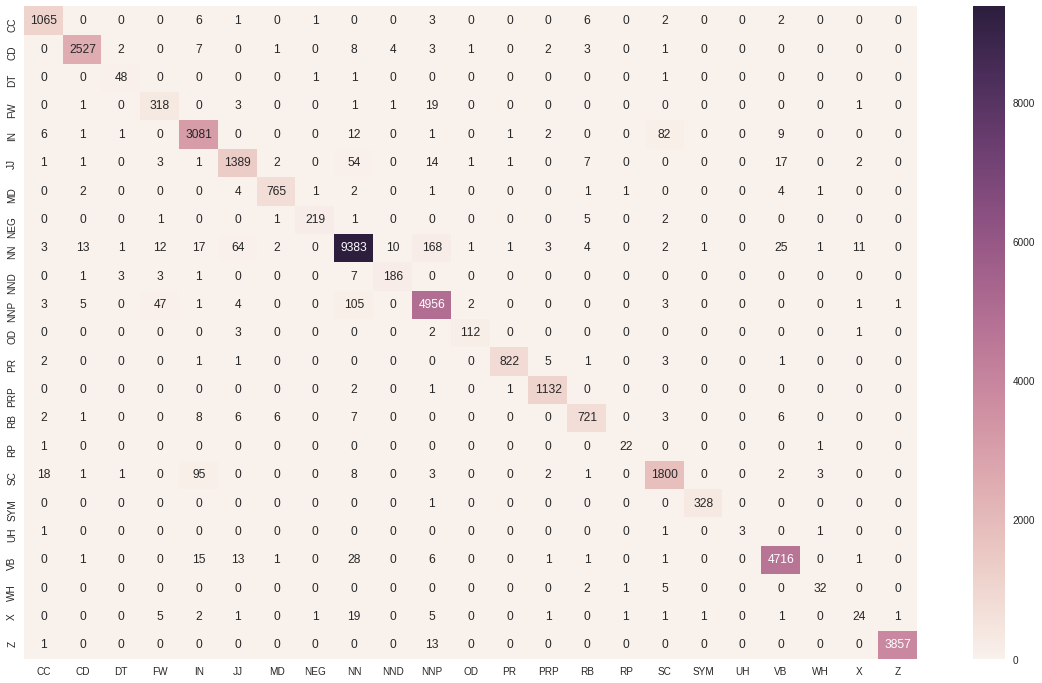

In [29]:
true_tag = [[a[1] for a in c] for c in test_sentences]
tokens, y_predict, y_true, _ = compare_result(result, true_tag)
print_evaluate(y_true, y_predict)

Load the trained logistic regression and its vectorizer

In [0]:
loaded_model = pickle.load(open('log_reg.meong', 'rb'))
vectorizer = pickle.load(open('vectorizer_lr.meong', 'rb'))
X_test, y_test = create_data_input_output(test_sentences)
X_transform_test = vectorizer.transform(X_test)


In [0]:
predicted = loaded_model.predict(X_transform_test)
counter = 0
processed = []
for test_sentence in test_sentences:
  range_postag = len(test_sentence)
  processed.append(predicted[counter:counter+range_postag].tolist())
  counter += range_postag

In [0]:
tokens, y_predict, y_true, y_predict_compare = compare_result(result, true_tag, processed)


## Evaluation of LogReg

Accuracy : 0.9381267445466763
              precision    recall  f1-score   support

          CC     0.9554    0.9853    0.9701      1086
          CD     0.9846    0.9769    0.9808      2559
          DT     0.9444    1.0000    0.9714        51
          FW     0.5929    0.8721    0.7059       344
          IN     0.9438    0.9406    0.9422      3196
          JJ     0.7757    0.9035    0.8348      1493
          MD     0.9696    0.9783    0.9739       782
         NEG     0.9784    0.9869    0.9826       229
          NN     0.9598    0.8868    0.9218      9722
         NND     0.6931    0.9552    0.8033       201
         NNP     0.9276    0.9222    0.9249      5128
          OD     0.7170    0.9661    0.8231       118
          PR     0.9964    0.9880    0.9922       836
         PRP     0.9800    0.9912    0.9856      1136
          RB     0.8604    0.9329    0.8952       760
          RP     0.8214    0.9583    0.8846        24
          SC     0.9034    0.9426    0.9226      19

(0.9381267445466763,
 {'CC': {'f1-score': 0.9700815956482322,
   'precision': 0.9553571428571429,
   'recall': 0.9852670349907919,
   'support': 1086},
  'CD': {'f1-score': 0.9807767752059632,
   'precision': 0.9846396218983852,
   'recall': 0.9769441187964049,
   'support': 2559},
  'DT': {'f1-score': 0.9714285714285714,
   'precision': 0.9444444444444444,
   'recall': 1.0,
   'support': 51},
  'FW': {'f1-score': 0.7058823529411765,
   'precision': 0.5928853754940712,
   'recall': 0.872093023255814,
   'support': 344},
  'IN': {'f1-score': 0.9421720733427363,
   'precision': 0.9437990580847724,
   'recall': 0.9405506883604505,
   'support': 3196},
  'JJ': {'f1-score': 0.8347772277227722,
   'precision': 0.7757331799884991,
   'recall': 0.9035498995311454,
   'support': 1493},
  'MD': {'f1-score': 0.9739019732654359,
   'precision': 0.9695817490494296,
   'recall': 0.9782608695652174,
   'support': 782},
  'NEG': {'f1-score': 0.9826086956521739,
   'precision': 0.9783549783549783,
   '

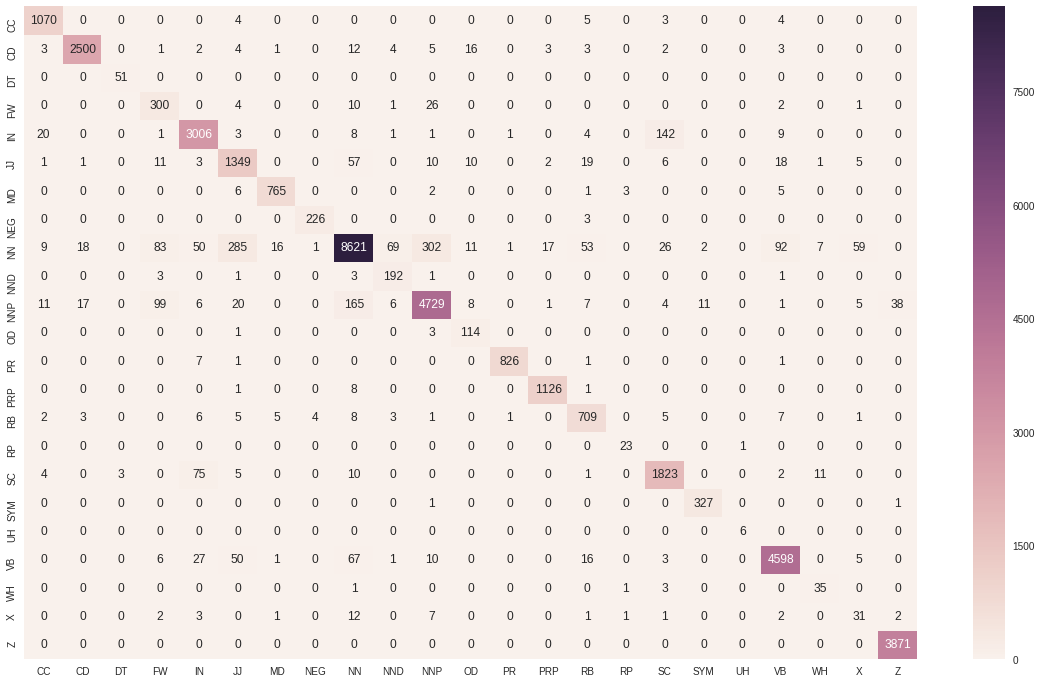

In [52]:
print_evaluate(y_true, y_predict_compare)

## Compare BERT and Feature Engineered Logistic Regression

In [0]:
compare_result_df = pd.DataFrame({"tokens": tokens, "y_predict" : y_predict, "y_true" : y_true, "y_predict_compare" : y_predict_compare})

In [0]:
compare_result_df.loc[:,'bert_success_pred'] = compare_result_df["y_predict"] == compare_result_df["y_true"]

In [0]:
compare_result_df.loc[:,'logreg_success_pred'] = compare_result_df["y_true"] == compare_result_df["y_predict_compare"]

In [0]:
bert_logreg = compare_result_df[(compare_result_df.bert_success_pred == True) &  (compare_result_df.logreg_success_pred == False)]

In [59]:
print("Bert Logreg shape is {}".format(bert_logreg.shape[0]))

Bert Logreg shape is 1673


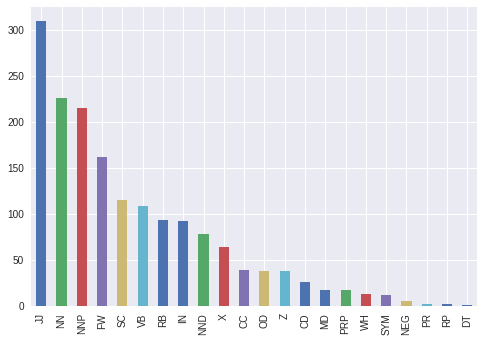

In [57]:
bert_logreg.y_predict_compare.value_counts().plot.bar()

In [0]:
logreg_bert = compare_result_df[(compare_result_df.bert_success_pred == False) &  (compare_result_df.logreg_success_pred == True)]

In [66]:
print("Bert Logreg shape is {}".format(logreg_bert.shape[0]))

Bert Logreg shape is 465


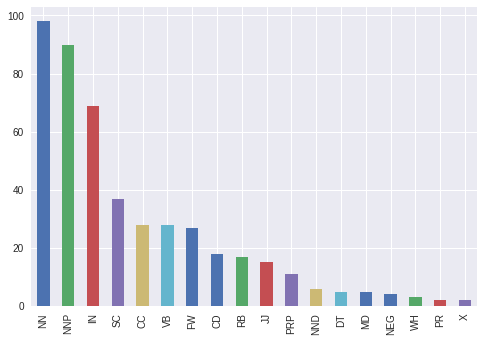

In [67]:
logreg_bert.y_predict.value_counts().plot.bar()

In [0]:
everything_wrong = compare_result_df[(compare_result_df.bert_success_pred == False) &  (compare_result_df.logreg_success_pred == False)]

In [70]:
print("All Wrong shape is {}".format(everything_wrong.shape[0]))

All Wrong shape is 721


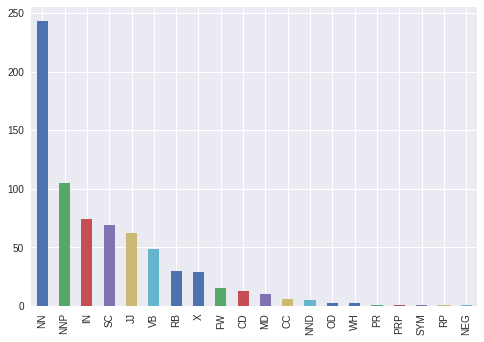

In [71]:
everything_wrong.y_true.value_counts().plot.bar()

In [0]:
def show_example_sample_df2(df, df_all, sample=7, max_tokens=6):
  if df.shape[0] == 0:
    print("None")
  else:
    df = df.sample(min(sample,df.shape[0]))
#     display(df)
    for i,tok in df.iterrows():
      display('Token : {}'.format(tok['tokens']),
              'Logreg : {}'.format(tok['y_predict_compare']), 
              'Bert : {}'.format(tok['y_predict']), 
              'Truth : {}'.format(tok['y_true']),
              ' '.join(df_all.iloc[i-max_tokens:i+max_tokens].tokens))
      print()

## See Logreg Vs Bert

### Bert TRUE Logreg FALSE

In [101]:
show_example_sample_df2(bert_logreg, compare_result_df, sample=30)

'Token : untuk'

'Logreg : SC'

'Bert : IN'

'Truth : IN'

'masuk ke kas PDI - Perjuangan untuk pemenangan pemilu pada tahun 2004'

'Token : lelaki'

'Logreg : NND'

'Bert : NN'

'Truth : NN'

', Senin , sedangkan jenazah dua lelaki warga sipil . Sejak itu'

'Token : orang'

'Logreg : NND'

'Bert : NN'

'Truth : NN'

'lalu dengan korban sedikit -nya 100 orang , akibat sebuah serangan pada'

'Token : bersih'

'Logreg : JJ'

'Bert : NN'

'Truth : NN'

'2 , perusahaan penyedia layanan air bersih dari aliran Citarum , dan'

'Token : Mudah-mudahan'

'Logreg : NN'

'Bert : SC'

'Truth : SC'

'tajam dari banyak ekonom muslim . Mudah-mudahan Jumat sampai Senin besok sudah'

'Token : karena'

'Logreg : SC'

'Bert : IN'

'Truth : IN'

'bersaudara , dipenjara selama 11,5 tahun karena pembunuhan seorang Armenia dengan motif'

'Token : nahas'

'Logreg : NN'

'Bert : JJ'

'Truth : JJ'

'November 2006 ke Jepang . Peristiwa nahas itu terjadi beberapa hari sebelum'

'Token : alas'

'Logreg : JJ'

'Bert : NN'

'Truth : NN'

'kebanyakan didominasi jenis barang-barang tekstil dan alas kaki . Tentu saja ada'

'Token : menengah'

'Logreg : JJ'

'Bert : NN'

'Truth : NN'

'yang sebagian besar dari kalangan kelas menengah juga mengadakan unjuk rasa tandingan'

'Token : diplomasi'

'Logreg : VB'

'Bert : NN'

'Truth : NN'

'mengatakan bahwa Washington menginginkan sebuah solusi diplomasi untuk mengakhiri ambisi nuklir Teheran'

'Token : dengan'

'Logreg : SC'

'Bert : IN'

'Truth : IN'

'kata sumber itu . Mereka berkejaran dengan kami dalam kecepatan yang sangat'

'Token : jelas'

'Logreg : JJ'

'Bert : VB'

'Truth : VB'

'diserahkan pada 28 Februari 2007 , jelas -nya . Margin bunga bersih'

'Token : bersama'

'Logreg : VB'

'Bert : IN'

'Truth : IN'

'Boediono , saat acara buka puasa bersama di Jakarta , Senin .'

'Token : Pasar'

'Logreg : NNP'

'Bert : NN'

'Truth : NN'

'tukar rupiah terhadap dolar AS di Pasar Spot Antar Bank Jakarta ,'

'Token : migas'

'Logreg : JJ'

'Bert : NN'

'Truth : NN'

'yang diberikan mencakup kegiatan-kegiatan spesifik sektor migas , seperti akuisisi dan pengolahan'

'Token : merah'

'Logreg : NN'

'Bert : JJ'

'Truth : JJ'

'diambil pemerintah untuk privatisasi baja plat merah ini masih mengemuka , selain'

'Token : agama'

'Logreg : SC'

'Bert : NN'

'Truth : NN'

'berusia 30 tahun yang telah memeluk agama Islam itu ditangkap di kota'

'Token : presiden'

'Logreg : NN'

'Bert : NNP'

'Truth : NNP'

'Singapura Lee Kuan Yew menemui wakil presiden Jusuf Kalla guna membicarakan prospek'

'Token : depan'

'Logreg : RB'

'Bert : NN'

'Truth : NN'

'bagi orang miskin besok atau bulan depan . Bisa saja orang Timur'

'Token : terburuk'

'Logreg : VB'

'Bert : JJ'

'Truth : JJ'

'Rusia Vladimir Putin di antara pelanggar terburuk . Namun rupiah secara perlahan-lahan'

'Token : ingat'

'Logreg : RB'

'Bert : NN'

'Truth : NN'

'penyakit Alzheimer , penyakit penurunan daya ingat yang merupakan bentuk paling umum'

'Token : antara'

'Logreg : IN'

'Bert : NN'

'Truth : NN'

'kelemahan politik Olmert dan perpecahan di antara rakyat Palestina . Perjanjian pinjaman'

'Token : Province'

'Logreg : FW'

'Bert : NNP'

'Truth : NNP'

'Sementara itu , polisi Nort Western Province menemukan mayat seorang warga negara'

'Token : seribu'

'Logreg : CC'

'Bert : CD'

'Truth : CD'

'militer AS . Tanpa itu , seribu macam pembahasan dan usulan solusi'

'Token : unit'

'Logreg : NND'

'Bert : NN'

'Truth : NN'

'Suzuki selama periode itu mencapai 250.000 unit , ujar -nya . Impor'

'Token : -'

'Logreg : Z'

'Bert : NNP'

'Truth : NNP'

'. Ketua PBB , Ban Ki - Moon , Senin menyerukan Israel'

'Token : diplomasi'

'Logreg : VB'

'Bert : NN'

'Truth : NN'

'laporan mengenai keberatan Israel atas pendekatan diplomasi ulang-alik AS tersebut . Sementara'

'Token : anjlok'

'Logreg : NN'

'Bert : VB'

'Truth : VB'

'2005 - 2006 penjualan kendaraan bermotor anjlok hingga 40 persen . Musuh'

'Token : dimensi'

'Logreg : VB'

'Bert : NN'

'Truth : NN'

'karena pendapatan terus Dihantam krisis multi dimensi , membuat kita jatuh tersungkur'

'Token : perdana'

'Logreg : OD'

'Bert : NN'

'Truth : NN'

'memperoleh sembilan kursi kabinet ditambah pos perdana menteri dan Fatah akan memperoleh'

## Bert FALSE Logreg TRUE

In [103]:
show_example_sample_df2(logreg_bert, compare_result_df, sample=30)

'Token : tidak'

'Logreg : X'

'Bert : NEG'

'Truth : X'

'Sebenarnya apa yang kita putuskan atau tidak - putuskan hari ini tidak'

'Token : perairan'

'Logreg : NN'

'Bert : NNP'

'Truth : NN'

'patroli Inggris pada 23 Maret di perairan Teluk Arab , sehingga menyulut'

'Token : pinjam'

'Logreg : NN'

'Bert : VB'

'Truth : NN'

'di sini tentu -nya koperasi simpan pinjam , yang kemudian harus mengikuti'

'Token : serial'

'Logreg : JJ'

'Bert : NN'

'Truth : JJ'

'sejumlah program televisi , termasuk di serial sukses Desperate Housewives . Seorang'

'Token : PKK'

'Logreg : NNP'

'Bert : NN'

'Truth : NNP'

'tewas sejak Partai Pekerja Kurdi ( PKK ) yang dicap organisasi teroris'

'Token : Seperti'

'Logreg : IN'

'Bert : PRP'

'Truth : IN'

'memiliki paten dalam hal teknologi . Seperti telah dikemukakan di atas pengembangan'

'Token : spot'

'Logreg : FW'

'Bert : NNP'

'Truth : FW'

'rupiah terhadap dolar AS di pasar spot antar bank Jakarta , Senin'

'Token : Rasa'

'Logreg : NN'

'Bert : VB'

'Truth : NN'

'liter dapat terealisasi pada 2009 . Rasa -nya , siapa pun tak'

'Token : Agreement'

'Logreg : NNP'

'Bert : FW'

'Truth : NNP'

"ini telah ditandatangani ' Heads of Agreement HOA oleh Direktur Utama PT"

'Token : margasatwa'

'Logreg : NN'

'Bert : NNP'

'Truth : NN'

'pemusnahan sebuah golongan bangsa . Pegiat margasatwa mengatakan singa tersebut juga menghadapi'

'Token : nyenyak'

'Logreg : JJ'

'Bert : VB'

'Truth : JJ'

'pagi , ketika orang lain masih nyenyak tidur , pada jam 2'

'Token : Dividen'

'Logreg : NN'

'Bert : FW'

'Truth : NN'

'tersebut ke negara tetangga Venezuela . Dividen ini akan dibagikan ke pemegang'

'Token : Small'

'Logreg : NNP'

'Bert : FW'

'Truth : NNP'

'ADB melalui Ditjen Perbendaharaan Depkeu untuk Small Medium Entreprice Export Development Project'

'Token : mayoritas'

'Logreg : NN'

'Bert : CD'

'Truth : NN'

'Maxis di NPS yang sebelum -nya mayoritas dimiliki kelompok Lippo . Hal'

'Token : untuk'

'Logreg : SC'

'Bert : IN'

'Truth : SC'

'pemerintah lokal dan internasional . Dana untuk pembelian 5 unit kapal itu'

'Token : Jangan'

'Logreg : NEG'

'Bert : NN'

'Truth : NEG'

'lebih kuat , kata -nya . Jangan ini diartikan bahwa dengan PMK'

'Token : Seorang'

'Logreg : NND'

'Bert : DT'

'Truth : NND'

'Bank of India sebagai mitra strategis Seorang pejabat setempat di Pulau Kish'

'Token : Jadi'

'Logreg : VB'

'Bert : SC'

'Truth : VB'

'pemimpin utama Mullah Mohammad Omar . Jadi belum ada kesepakatan , kata'

'Token : dan'

'Logreg : CC'

'Bert : NNP'

'Truth : CC'

'AS , kata Direktur Riset Ekonomi dan Kebijakan Moneter BI , Made'

'Token : Ada'

'Logreg : VB'

'Bert : IN'

'Truth : VB'

'tahun 1981 dan tahun 1984 . Ada banyak keuntungan bagi Indonesia untuk'

'Token : Semua'

'Logreg : CD'

'Bert : IN'

'Truth : CD'

'Negeri Indonesia M. Ibnu Said . Semua kredit naik 0,75 persen Tidak'

'Token : sejumlah'

'Logreg : CD'

'Bert : NN'

'Truth : CD'

'Pada suatu hari terpaksa meminjam uang sejumlah Rp 1 juta dari pelepas'

'Token : Tidak'

'Logreg : NEG'

'Bert : SC'

'Truth : NEG'

'Rp 83,48 triliun , demikian dikutip Tidak perlu dengan kuliah di fakultas'

'Token : Setelah'

'Logreg : SC'

'Bert : CC'

'Truth : SC'

'Departemen Keuangan Jakarta , Rabu . Setelah diperdagangkan pada kisaran antara 1.409,71'

'Token : siapa'

'Logreg : WH'

'Bert : SC'

'Truth : WH'

'pada 2009 . Rasa -nya , siapa pun tak akan tenang hati'

'Token : belanja'

'Logreg : NN'

'Bert : VB'

'Truth : NN'

', dengan ditemani suami -nya dia belanja sayur-mayur di pasar Parung .'

'Token : -'

'Logreg : Z'

'Bert : NNP'

'Truth : Z'

"kedalaman 17 ' pada pasir Cris - K2 , kata -nya ."

'Token : konsuler'

'Logreg : JJ'

'Bert : NN'

'Truth : JJ'

'jawaban atas permintaan -nya bagi akses konsuler kelima orang tersebut . Sebelum'

'Token : LPBN'

'Logreg : NNP'

'Bert : NN'

'Truth : NNP'

"Fitch menaikkan Peringkat Nasional Jangka Panjang LPBN ke ' AA - idn"

'Token : dan'

'Logreg : CC'

'Bert : NNP'

'Truth : CC'

'23 pengusaha Wapres dalam Rakernas Akuntansi dan Pelaporan Keuangan Pemerintah di Jakarta'

## BERT FALSE Logreg FALSE

In [106]:
show_example_sample_df2(everything_wrong, compare_result_df, sample=20)

'Token : Muslim'

'Logreg : NNP'

'Bert : NNP'

'Truth : NN'

'urusan , tapi memerangi Islam and Muslim . Transaksi berjalan tercatat surplus'

'Token : mengaju'

'Logreg : VB'

'Bert : VB'

'Truth : X'

'. Pejuang di daerah suku Pakistan mengaju sejumlah orang beberapa bulan terakhir'

'Token : dengan'

'Logreg : SC'

'Bert : SC'

'Truth : IN'

'sama pada 2 tahun terakhir , dengan catatan tidak memasukkan program luncuran'

'Token : Akuntansi'

'Logreg : NNP'

'Bert : NNP'

'Truth : NN'

'atau 23 pengusaha Wapres dalam Rakernas Akuntansi dan Pelaporan Keuangan Pemerintah di'

'Token : sakit'

'Logreg : NN'

'Bert : NN'

'Truth : NNP'

'berdatangan , kata dokter di rumah sakit Donka di Konakri itu ,'

'Token : muda'

'Logreg : JJ'

'Bert : JJ'

'Truth : NN'

'merupakan pembunuh terkemuka di kalangan anak muda pada tahun 2006 , yang'

'Token : Reguler'

'Logreg : NNP'

'Bert : NNP'

'Truth : JJ'

'Central Korporindo Internasional CNKO di Pasar Reguler dan Pasar Tunai sejak sesi'

'Token : tujuh'

'Logreg : CD'

'Bert : CD'

'Truth : NN'

'mengatakan , secara kumulatif surplus perdagangan tujuh bulan pertama 2007 mencapai 23,64'

'Token : FCL'

'Logreg : NNP'

'Bert : FW'

'Truth : X'

'milik PT PRG sebanyak 15 kontainer FCL di Jawa Barat dan 1'

'Token : untuk'

'Logreg : SC'

'Bert : SC'

'Truth : IN'

'ke Asia , termasuk ke Indonesia untuk berbisnis tanpa ada kaitan dengan'

'Token : se-Afrika'

'Logreg : SC'

'Bert : NNP'

'Truth : NN'

'di perkreditan mulai bergulir . Badan se-Afrika itu mengambil alih kepemimpinan dari'

'Token : Adapun'

'Logreg : SC'

'Bert : IN'

'Truth : CC'

'lah berbagai bantuan kepada mereka . Adapun Martinovich - yang sempat disebut'

'Token : Paripurna'

'Logreg : NNP'

'Bert : NNP'

'Truth : NN'

'Susilo Bambang Yudhoyono di depan Rapat Paripurna DPR RI di Jakarta ,'

'Token : Pelaporan'

'Logreg : NNP'

'Bert : NNP'

'Truth : NN'

'pengusaha Wapres dalam Rakernas Akuntansi dan Pelaporan Keuangan Pemerintah di Jakarta ,'

'Token : dengan'

'Logreg : IN'

'Bert : IN'

'Truth : SC'

'Mereka mengajukan pertanyaan kepada -nya berkaitan dengan peledakan bom pinggir jalan .'

'Token : non'

'Logreg : RB'

'Bert : FW'

'Truth : NEG'

'Krakatau Steel mendapatkan fasilitas kredit berupa non cash loan dari BNI sebesar'

'Token : nol'

'Logreg : FW'

'Bert : NN'

'Truth : CD'

', serta SBN yang memiliki bunga nol zero coupon Rp 3,9 triliun'

'Token : Arti'

'Logreg : IN'

'Bert : JJ'

'Truth : NN'

'yang mencakup mengobarkan kekerasan etnik . Arti -nya perbankan mengucurkan kredit kepada'

'Token : ajar'

'Logreg : JJ'

'Bert : NN'

'Truth : VB'

'di Bolivia merupakan hasil saling - ajar antara pengawas bank selama mengawasi'

'Token : Fraksi'

'Logreg : NN'

'Bert : NN'

'Truth : NNP'

'-nya di Jakarta , Selasa . Fraksi PAN , melalui Ketua fraksi'